In [ ]:
!pip install arch
from arch import arch_model


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 61.5 MB/s eta 0:00:00


In [ ]:
!nvidia-smi


Wed Dec 10 18:03:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   44C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
"""
Hybrid GARCH(1,1) + Conv1d Neural Network Model with Dynamic Volatility Layer

The NN learns a persistence parameter C = α + β and a split factor ρ from historical data.
From (C, ρ) it reconstructs (α, β), which are then passed with ω to a differentiable GARCH
layer to predict the next conditional variance.

This implementation includes:
- Proper train/validation/test split
- Global standardisation of returns before NN and arch_model
- Training on log-variance log(σ²) instead of raw σ²
- Extensive diagnostic visualizations
- Parameter learning tracking over epochs
- Extra plots: α_true vs α_pred on train / val / test
"""

from arch import arch_model

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple, List

# ============================================================================
# 1. DATA GENERATION: GARCH(1,1) Process
# ============================================================================

class GARCHGenerator:
    """
    PyTorch-based GARCH(1,1) data generator.

    GARCH(1,1) recursion:
        σ²_t = ω + α·r²_{t-1} + β·σ²_{t-1}
        r_t = σ_t·ε_t, where ε_t ~ N(0,1)
    """

    def __init__(self, omega: float, alpha: float, beta: float,
                 n_samples: int, seed: int = 42):
        """
        Args:
            omega: Constant term (ω > 0)
            alpha: ARCH coefficient (α ≥ 0)
            beta: GARCH coefficient (β ≥ 0)
            n_samples: Number of time steps to generate
            seed: Random seed for reproducibility
        """
        self.omega = omega
        self.alpha = alpha
        self.beta = beta
        self.n_samples = n_samples

        # Verify stationarity: α + β < 1
        assert alpha + beta < 1.0, f"Non-stationary: α + β = {alpha + beta} >= 1"
        assert omega > 0 and alpha >= 0 and beta >= 0, "Parameters must be positive"

        torch.manual_seed(seed)

    def generate_series(self) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Generate complete time series.

        Returns:
            tuple: (returns, conditional_variances) as torch tensors
        """
        # Initialize with unconditional variance
        sigma2 = self.omega / (1.0 - self.alpha - self.beta)
        r_prev = 0.0

        returns = []
        variances = []

        for _ in range(self.n_samples):
            # GARCH recursion
            sigma2 = self.omega + self.alpha * (r_prev ** 2) + self.beta * sigma2
            variances.append(sigma2)

            # Generate return
            epsilon = torch.randn(1).item()
            r_t = np.sqrt(sigma2) * epsilon
            returns.append(r_t)

            r_prev = r_t

        return torch.tensor(returns, dtype=torch.float32), \
               torch.tensor(variances, dtype=torch.float32)


# ============================================================================
# 1.Bis: recompute σ² from params (for arch_model comparison)
# ============================================================================

def compute_garch_variance_from_params(returns: np.ndarray,
                                       omega: float,
                                       alpha: float,
                                       beta: float) -> np.ndarray:
    """
    Recompute conditional variances σ_t^2 from returns and GARCH(1,1) params.
    returns: array of shape [T]
    """
    T = len(returns)
    sigma2 = np.zeros(T)
    # Unconditional variance as starting point
    denom = max(1e-4, 1.0 - alpha - beta)
    sigma2[0] = omega / denom

    for t in range(1, T):
        sigma2[t] = omega + alpha * (returns[t-1]**2) + beta * sigma2[t-1]

    return sigma2


# ============================================================================
# 2. NEURAL NETWORK FOR PARAMETER PREDICTION
# ============================================================================

class GARCHParameterNet(nn.Module):
    """
    Neural network that learns to predict:
      - a level parameter ω > 0,
      - a persistence parameter C = α + β ∈ (0, C_max),
      - a split factor ρ ∈ (0, 1) such that α = Cρ and β = C(1−ρ),

    from historical returns. The resulting (ω, α, β) are then used in a GARCH(1,1)
    recursion to produce one-step-ahead conditional variances.

    Architecture: 1D convolutional encoder → MLP → (ω, C, ρ) heads with constraints.
    """

    def __init__(self, input_seq_len: int, hidden_dim: int = 64,
                 num_conv_layers: int = 2, kernel_size: int = 5):
        super(GARCHParameterNet, self).__init__()

        self.input_seq_len = input_seq_len
        self.hidden_dim = hidden_dim

        # --- Temporal encoder with 1D convolutions ---
        padding = kernel_size // 2  # keep same length T

        convs = []
        in_channels = 1
        for _ in range(num_conv_layers):
            convs.append(
                nn.Conv1d(
                    in_channels=in_channels,
                    out_channels=hidden_dim,
                    kernel_size=kernel_size,
                    padding=padding
                )
            )
            convs.append(nn.ReLU())
            in_channels = hidden_dim

        self.conv_net = nn.Sequential(*convs)

        # --- MLP for parameter prediction ---
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)

        # Heads:
        #   - omega_head : level parameter ω > 0
        #   - c_head     : persistence C = α+β in (0, C_max)
        #   - rho_head   : split factor ρ in (0,1) so α = Cρ, β = C(1-ρ)
        self.omega_head = nn.Linear(hidden_dim // 2, 1)
        self.c_head     = nn.Linear(hidden_dim // 2, 1)
        self.rho_head   = nn.Linear(hidden_dim // 2, 1)

        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights with Xavier for conv & linear layers."""
        for name, param in self.named_parameters():
            if 'weight' in name and param.dim() >= 2:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Args:
            x: Input returns [batch_size, seq_len, 1]

        Returns:
            tuple: (ω, α, β) as torch tensors [batch_size]
        """
        # x : [B, T, 1] → [B, 1, T] for Conv1d
        x = x.transpose(1, 2)  # [B, 1, T]

        # Conv1d encoder
        x = self.conv_net(x)   # [B, hidden_dim, T]

        # Global average pooling over time
        x = x.mean(dim=2)      # [B, hidden_dim]

        # MLP
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))  # [B, hidden_dim // 2]

        # Raw parameters
        omega_raw = self.omega_head(x)
        c_raw     = self.c_head(x)
        rho_raw   = self.rho_head(x)

        # ω > 0 via softplus
        omega = torch.nn.functional.softplus(omega_raw) + 1e-6

        # C = α+β in (0, C_max) to enforce stationarity
        C_max = 0.99                   # persistence upper bound < 1
        C = torch.sigmoid(c_raw) * C_max   # C ∈ (0, C_max)

        # ρ in (0,1) controls how C is split between α and β
        rho = torch.sigmoid(rho_raw)       # ρ ∈ (0,1)

        # α = Cρ, β = C(1−ρ) ⇒ α ≥ 0, β ≥ 0, α+β = C < 1
        alpha = C * rho
        beta  = C * (1.0 - rho)

        return omega.squeeze(-1), alpha.squeeze(-1), beta.squeeze(-1)


# ============================================================================
# 3. DIFFERENTIABLE GARCH VOLATILITY LAYER
# ============================================================================

class GARCHVolatilityLayer(nn.Module):
    """
    Differentiable GARCH layer that computes conditional variance recursively.

    This layer embeds memory (past shocks and past variance) directly into
    the forward pass, similar to recurrent architectures.
    """

    def __init__(self):
        super(GARCHVolatilityLayer, self).__init__()

    def forward(self, returns_window: torch.Tensor, omega: torch.Tensor,
                alpha: torch.Tensor, beta: torch.Tensor) -> torch.Tensor:
        """
        Compute conditional variance using GARCH recursion.

        Args:
            returns_window: Past returns [batch_size, seq_len, 1]
            omega: ω parameter [batch_size]
            alpha: α parameter [batch_size]
            beta: β parameter [batch_size]

        Returns:
            torch.Tensor: Next conditional variance σ²_{t+1} [batch_size]
        """
        batch_size = returns_window.size(0)
        seq_len = returns_window.size(1)

        # Initialize with unconditional variance
        sigma2 = omega / (1.0 - alpha - beta + 1e-8)

        # Flatten returns for iteration
        returns_seq = returns_window.squeeze(-1)  # [batch_size, seq_len]

        # GARCH recursion: σ²_t = ω + α·r²_{t-1} + β·σ²_{t-1}
        for t in range(seq_len):
            r_t = returns_seq[:, t]
            sigma2 = omega + alpha * (r_t ** 2) + beta * sigma2

        return sigma2


# ============================================================================
# 4. HYBRID MODEL: NN + GARCH VOLATILITY LAYER
# ============================================================================

class HybridGARCHModel(nn.Module):
    """
    Hybrid model: NN learns parameters → GARCH layer computes volatility

    Flow:
        Historical returns → Parameter NN → (ω, α, β) → GARCH Layer → σ²_{t+1}
    """

    def __init__(self, input_seq_len: int, hidden_dim: int = 64):
        super(HybridGARCHModel, self).__init__()

        self.param_net = GARCHParameterNet(input_seq_len, hidden_dim)
        self.volatility_layer = GARCHVolatilityLayer()

    def forward(self, returns_window: torch.Tensor) -> Tuple[torch.Tensor,
                                                             torch.Tensor,
                                                             torch.Tensor,
                                                             torch.Tensor]:
        """
        Forward pass: predict next conditional variance.

        Args:
            returns_window: Historical returns [batch_size, seq_len, 1]

        Returns:
            tuple: (predicted_variance, omega, alpha, beta)
        """
        # Step 1: NN predicts GARCH parameters from historical data
        omega, alpha, beta = self.param_net(returns_window)

        # Step 2: GARCH layer computes conditional variance using learned parameters
        sigma2_pred = self.volatility_layer(returns_window, omega, alpha, beta)

        return sigma2_pred, omega, alpha, beta


# ============================================================================
# 5. DATASET WITH TRAIN/VAL/TEST SPLIT
# ============================================================================

class MultiGARCHDataset(Dataset):
    """
    Dataset for MULTIPLE GARCH time series with sliding windows.

    Inputs:
        returns_mat:   [n_series, series_len]
        variances_mat: [n_series, series_len]
    Each sample is:
        (window_of_returns, target_variance_at_t+window)
    from some series j, some starting time t.
    """

    def __init__(self, returns_mat: torch.Tensor,
                 variances_mat: torch.Tensor,
                 window_size: int):
        assert returns_mat.shape == variances_mat.shape
        self.returns = returns_mat
        self.variances = variances_mat
        self.window_size = window_size

        self.n_series, self.series_len = self.returns.shape
        self.windows_per_series = self.series_len - window_size
        self.n_samples = self.n_series * self.windows_per_series

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        # Map global idx -> (series_idx, time_idx)
        series_idx = idx // self.windows_per_series
        t = idx % self.windows_per_series

        # Input window: [window_size, 1]
        window = self.returns[series_idx, t:t + self.window_size].unsqueeze(-1)

        # Target variance: σ²_{t+window}
        target_var = self.variances[series_idx, t + self.window_size]

        return window, target_var





# ============================================================================
# 6. TRAINING WITH VALIDATION (LOSS ON LOG-VARIANCE)
# ============================================================================

def train_epoch(model: nn.Module, train_loader: DataLoader,
                optimizer: optim.Optimizer, criterion: nn.Module,
                device: str) -> Tuple[float, float, float, float]:
    """Train for one epoch (MSE on log-variance)."""
    model.train()
    total_loss = 0.0
    total_omega = 0.0
    total_alpha = 0.0
    total_beta = 0.0
    n_batches = 0
    eps = 1e-8

    for batch_returns, batch_target_var in train_loader:
        batch_returns = batch_returns.to(device, non_blocking=True)
        batch_target_var = batch_target_var.to(device, non_blocking=True)

        optimizer.zero_grad()

        # Forward pass
        pred_var, omega, alpha, beta = model(batch_returns)

        # MSE loss between predicted and true *log-variance*
        pred_logvar = torch.log(pred_var + eps)
        true_logvar = torch.log(batch_target_var + eps)
        loss = criterion(pred_logvar, true_logvar)

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Accumulate statistics
        total_loss += loss.item()
        total_omega += omega.mean().item()
        total_alpha += alpha.mean().item()
        total_beta += beta.mean().item()
        n_batches += 1

    return (total_loss / n_batches, total_omega / n_batches,
            total_alpha / n_batches, total_beta / n_batches)


def validate(model: nn.Module, val_loader: DataLoader,
             criterion: nn.Module, device: str) -> Tuple[float, float, float, float]:
    """Validate the model (MSE on log-variance)."""
    model.eval()
    total_loss = 0.0
    total_omega = 0.0
    total_alpha = 0.0
    total_beta = 0.0
    n_batches = 0
    eps = 1e-8

    with torch.no_grad():
        for batch_returns, batch_target_var in val_loader:
            batch_returns = batch_returns.to(device)
            batch_target_var = batch_target_var.to(device)

            pred_var, omega, alpha, beta = model(batch_returns)

            pred_logvar = torch.log(pred_var + eps)
            true_logvar = torch.log(batch_target_var + eps)
            loss = criterion(pred_logvar, true_logvar)

            total_loss += loss.item()
            total_omega += omega.mean().item()
            total_alpha += alpha.mean().item()
            total_beta += beta.mean().item()
            n_batches += 1

    return (total_loss / n_batches, total_omega / n_batches,
            total_alpha / n_batches, total_beta / n_batches)


def train_hybrid_garch(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    n_epochs: int,
    learning_rate: float,
    device: str,
    checkpoint_path: str = "best_garch_model.pt",   # ← paramétré ici
    load_best: bool = True,
) -> dict:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                     factor=0.5, patience=10)
    criterion = nn.MSELoss()

    history = {
        'train_loss': [], 'val_loss': [],
        'train_omega': [], 'train_alpha': [], 'train_beta': [],
        'val_omega': [], 'val_alpha': [], 'val_beta': []
    }

    print("Starting training...")
    print(f"{'Epoch':<8} {'Train Loss':<12} {'Val Loss':<12} "
          f"{'Train α':<10} {'Train β':<10} {'Val α':<10} {'Val β':<10}")
    print("-" * 80)

    best_val_loss = float('inf')

    for epoch in range(n_epochs):
        # Train
        train_loss, train_omega, train_alpha, train_beta = train_epoch(
            model, train_loader, optimizer, criterion, device)

        # Validate
        val_loss, val_omega, val_alpha, val_beta = validate(
            model, val_loader, criterion, device)

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_omega'].append(train_omega)
        history['train_alpha'].append(train_alpha)
        history['train_beta'].append(train_beta)
        history['val_omega'].append(val_omega)
        history['val_alpha'].append(val_alpha)
        history['val_beta'].append(val_beta)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), checkpoint_path)

        # Print progress
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"{epoch+1:<8} {train_loss:<12.6f} {val_loss:<12.6f} "
                  f"{train_alpha:<10.6f} {train_beta:<10.6f} "
                  f"{val_alpha:<10.6f} {val_beta:<10.6f}")

    print(f"\nTraining completed! Best validation loss (log-variance MSE): {best_val_loss:.6f}")

    # Optionnel : recharger le meilleur modèle
    if load_best:
        model.load_state_dict(torch.load(checkpoint_path))

    return history



def plot_training_curves(history: dict, save_path: str = "training_curves.png"):
    """
    Plot training & validation loss over epochs and save to file.
    Here the loss is MSE on log-variance.
    """
    train_loss = history['train_loss']
    val_loss = history['val_loss']
    epochs = np.arange(1, len(train_loss) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss (log σ̂² vs log σ²)")
    plt.title("Training and Validation Loss over Epochs")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved training curves to '{save_path}'")
    plt.show()


# ============================================================================
# 7. FORECAST COMPARISON NN vs ARCH ON ONE SERIES
# ============================================================================
# ============================================================================
# 7. FORECAST COMPARISON NN vs ARCH ON ONE SERIES
# ============================================================================

def plot_forecast_comparison_nn_vs_arch(
    model: nn.Module,
    val_returns: torch.Tensor,        # [N_SERIES, val_len], déjà standardisé
    true_val_sigma2: np.ndarray,      # [N_SERIES, val_len], σ² (scaled)
    arch_val_sigma2: np.ndarray,      # [N_SERIES, val_len], σ̂² GARCH (scaled)
    window_size: int,
    device: torch.device,
    series_idx: int = 0,
    save_path: str = "sigma2_forecast_nn_vs_arch_series0.png",
):
    """
    Compare, sur UNE série de validation, la variance "vraie" vs
    la prévision NN–GARCH vs la prévision GARCH(1,1).

    Tout est sur le process standardisé (retours centrés, divisés par std).
    """

    model.eval()

    # ---- 1) Compute NN forecasts σ̂²_{t+1} sur la série de validation ----
    with torch.no_grad():
        nn_sigma2_list = []
        val_len = val_returns.shape[1]

        for t in range(val_len - window_size):
            # fenêtre [t, ..., t+window_size-1]
            window = val_returns[series_idx, t:t+window_size]       # [window_size]
            window = window.unsqueeze(0).unsqueeze(-1).to(device)   # [1, W, 1]

            pred_var, _, _, _ = model(window)   # [1]
            nn_sigma2_list.append(pred_var.item())

    nn_sigma2 = np.array(nn_sigma2_list)  # longueur = val_len - window_size

    # ---- 2) Align avec vrai σ² et σ̂² GARCH ----
    t_idx = np.arange(window_size, val_len)      # indices t+WINDOW_SIZE

    true_series = true_val_sigma2[series_idx, window_size:]   # [val_len - W]
    arch_series = arch_val_sigma2[series_idx, window_size:]   # [val_len - W]

    # ---- 3) Plot ----
    plt.figure(figsize=(10, 5))
    plt.plot(t_idx, true_series, label="True σ² (scaled)", alpha=0.9)
    plt.plot(t_idx, nn_sigma2,  label="NN–GARCH σ̂² (scaled)", alpha=0.9)
    plt.plot(t_idx, arch_series, label="GARCH(1,1) σ̂² (scaled)", alpha=0.9)

    plt.xlabel("Validation time index")
    plt.ylabel("Variance σ² (scaled)")
    plt.title(f"σ² forecast – series {series_idx}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"Saved NN vs ARCH forecast comparison to '{save_path}'")
    plt.show()



def plot_forecast_pre_vs_ft_vs_arch(
    model_pre: nn.Module,
    model_ft: nn.Module,
    val_returns: torch.Tensor,       # [N_SERIES, val_len] wac
    true_val_sigma2: np.ndarray,     # [N_SERIES, val_len]
    arch_val_sigma2: np.ndarray,     # [N_SERIES, val_len]
    window_size: int,
    device: torch.device,
    series_idx: int = 0,
    save_path: str = "sigma2_forecast_pre_vs_ft_vs_arch_series0.png",
):
    """
    Compare, sur une série de validation, la variance vraie vs :
      - NN–GARCH pré-entraîné (synthetic only)
      - NN–GARCH fine-tuné (real)
      - GARCH(1,1) (arch)
    Tout est sur le process standardisé.
    """

    model_pre.eval()
    model_ft.eval()

    val_len = val_returns.shape[1]

    nn_pre_list = []
    nn_ft_list  = []

    with torch.no_grad():
        for t in range(val_len - window_size):
            # fenêtre [t, ..., t+W-1]
            window = val_returns[series_idx, t:t+window_size]      # [W]
            window = window.unsqueeze(0).unsqueeze(-1).to(device)  # [1, W, 1]

            # pré-entraîné
            pred_pre, _, _, _ = model_pre(window)
            nn_pre_list.append(pred_pre.item())

            # fine-tuné
            pred_ft, _, _, _ = model_ft(window)
            nn_ft_list.append(pred_ft.item())

    nn_pre_sigma2 = np.array(nn_pre_list)   # len = val_len - W
    nn_ft_sigma2  = np.array(nn_ft_list)

    # indices temporels pour σ²_{t+1} associé à la fenêtre [t,...,t+W-1]
    t_idx       = np.arange(window_size, val_len)
    true_series = true_val_sigma2[series_idx, window_size:]
    arch_series = arch_val_sigma2[series_idx, window_size:]

    plt.figure(figsize=(10, 5))
    plt.plot(t_idx, true_series,    label="True σ² (scaled)", alpha=0.9)
    plt.plot(t_idx, nn_pre_sigma2,  label="NN–GARCH pretrain σ̂²", alpha=0.9)
    plt.plot(t_idx, nn_ft_sigma2,   label="NN–GARCH finetune σ̂²", alpha=0.9)
    plt.plot(t_idx, arch_series,    label="GARCH(1,1) σ̂²", alpha=0.9)

    plt.xlabel("Validation time index")
    plt.ylabel("Variance σ² (scaled)")
    plt.title(f"σ² forecast – series {series_idx}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"Saved 3-way forecast comparison to '{save_path}'")
    plt.show()



# ============================================================================
# 8. UTILS: collect α per series & plots α_true vs α_pred (train/val/test)
# ============================================================================

def collect_alpha_per_series(model: nn.Module,
                             dataset: MultiGARCHDataset,
                             device: str,
                             batch_size: int = 256) -> np.ndarray:
    """
    Collect mean predicted α per series over all windows of a given dataset.
    """
    model.eval()
    loader = DataLoader(dataset, batch_size=batch_size,
                        shuffle=False, num_workers=0)

    alphas_list = []

    with torch.no_grad():
        for batch_returns, batch_target_var in loader:
            batch_returns = batch_returns.to(device)
            pred_var, omega, alpha, beta = model(batch_returns)
            alphas_list.append(alpha.cpu())

    alphas_all = torch.cat(alphas_list).numpy()   # [n_samples]

    n_series = dataset.n_series
    windows_per_series = dataset.windows_per_series
    n_samples = len(dataset)
    assert n_samples == n_series * windows_per_series, \
        "Unexpected shapes in collect_alpha_per_series."

    sample_idx = np.arange(n_samples)
    series_idx = sample_idx // windows_per_series  # [n_samples] in [0, n_series-1]

    alpha_hat = np.zeros(n_series)
    for j in range(n_series):
        mask = (series_idx == j)
        alpha_hat[j] = alphas_all[mask].mean()

    return alpha_hat


def plot_alpha_true_vs_pred(alpha_true: np.ndarray,
                            alpha_pred: np.ndarray,
                            split_name: str,
                            save_path: str):
    """
    Scatter plot α_true vs α_pred for a given split (train / val / test).
    """
    plt.figure(figsize=(6, 6))
    plt.scatter(alpha_true, alpha_pred, alpha=0.7)
    min_a = min(alpha_true.min(), alpha_pred.min())
    max_a = max(alpha_true.max(), alpha_pred.max())
    plt.plot([min_a, max_a], [min_a, max_a], 'r--', label='y=x')
    plt.xlabel("True α")
    plt.ylabel("Predicted α")
    plt.title(f"α: True vs Predicted ({split_name})")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved {split_name} α true vs predicted scatter to '{save_path}'")
    plt.show()


# ============================================================================
# 9. COMPREHENSIVE VISUALIZATION ON VALIDATION SPLIT
# ============================================================================

def create_visualizations_multi(
    model: nn.Module,
    val_dataset: MultiGARCHDataset,
    true_omegas: np.ndarray,
    true_alphas: np.ndarray,
    true_betas:  np.ndarray,
    device: str,
    batch_size: int = 256,
    garch_omegas: np.ndarray = None,
    garch_alphas: np.ndarray = None,
    garch_betas:  np.ndarray = None,
):
    """
    Multi-series visualization on the VALIDATION set:
    - aggregate predicted parameters over all windows of each series
    - compare true vs predicted (ω, α, β)
    - optionally compare NN vs arch_model
    - show histograms and scatter plots
    """

    model.eval()

    # ---------- 1. Collect predictions on the validation set ----------
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                            shuffle=False, num_workers=0)

    preds_list = []
    targets_list = []
    omegas_list = []
    alphas_list = []
    betas_list = []

    with torch.no_grad():
        for batch_returns, batch_target_var in val_loader:
            batch_returns = batch_returns.to(device)
            batch_target_var = batch_target_var.to(device)

            pred_var, omega, alpha, beta = model(batch_returns)

            preds_list.append(pred_var.cpu())
            targets_list.append(batch_target_var.cpu())
            omegas_list.append(omega.cpu())
            alphas_list.append(alpha.cpu())
            betas_list.append(beta.cpu())

    val_preds   = torch.cat(preds_list).numpy()   # [n_val_samples]
    val_targets = torch.cat(targets_list).numpy() # [n_val_samples]
    val_omegas  = torch.cat(omegas_list).numpy()  # [n_val_samples]
    val_alphas  = torch.cat(alphas_list).numpy()  # [n_val_samples]
    val_betas   = torch.cat(betas_list).numpy()   # [n_val_samples]

    # Basic prediction metrics on variance (on scaled σ²)
    val_mse = np.mean((val_preds - val_targets) ** 2)
    val_mae = np.mean(np.abs(val_preds - val_targets))
    val_r2  = np.corrcoef(val_targets, val_preds)[0, 1] ** 2

    print("\n[Multi-Series] Variance prediction quality on validation set (scaled σ²):")
    print(f"  Val MSE: {val_mse:.4e}")
    print(f"  Val MAE: {val_mae:.4e}")
    print(f"  Val R² : {val_r2:.4f}")

    # ---------- 2. Aggregate parameter predictions per series ----------

    n_series = val_dataset.n_series
    windows_per_series = val_dataset.windows_per_series

    n_val_samples = len(val_preds)
    assert n_val_samples == n_series * windows_per_series, \
        "Unexpected shapes: val_samples != n_series * windows_per_series"

    sample_idx = np.arange(n_val_samples)
    series_idx = sample_idx // windows_per_series  # [n_val_samples] in [0, n_series-1]

    omega_hat = np.zeros(n_series)
    alpha_hat = np.zeros(n_series)
    beta_hat  = np.zeros(n_series)

    for j in range(n_series):
        mask = (series_idx == j)
        omega_hat[j] = val_omegas[mask].mean()
        alpha_hat[j] = val_alphas[mask].mean()
        beta_hat[j]  = val_betas[mask].mean()

    omega_true = np.asarray(true_omegas)
    alpha_true = np.asarray(true_alphas)
    beta_true  = np.asarray(true_betas)

    # ---------- 3. Compute errors across series (NN) ----------

    omega_err = omega_hat - omega_true
    alpha_err = alpha_hat - alpha_true
    beta_err  = beta_hat  - beta_true

    omega_abs_err = np.abs(omega_err)
    alpha_abs_err = np.abs(alpha_err)
    beta_abs_err  = np.abs(beta_err)

    # Avoid div-by-zero for relative errors
    omega_rel_err = omega_abs_err / (np.abs(omega_true) + 1e-8)
    alpha_rel_err = alpha_abs_err / (np.abs(alpha_true) + 1e-8)
    beta_rel_err  = beta_abs_err / (np.abs(beta_true) + 1e-8)

    print("\n[Multi-Series] Parameter error summary (NN, validation):")
    print(f"  Mean |ω_hat - ω|      : {omega_abs_err.mean():.4e}")
    print(f"  Mean |α_hat - α|      : {alpha_abs_err.mean():.4e}")
    print(f"  Mean |β_hat - β|      : {beta_abs_err.mean():.4e}")
    print(f"  Mean rel error ω      : {omega_rel_err.mean()*100:.2f}%")
    print(f"  Mean rel error α      : {alpha_rel_err.mean()*100:.2f}%")
    print(f"  Mean rel error β      : {beta_rel_err.mean()*100:.2f}%")

    # ---------- 3bis. Compare with classical GARCH(1,1) (arch_model) ----------

    if (garch_omegas is not None) and (garch_alphas is not None) and (garch_betas is not None):
        garch_omegas = np.asarray(garch_omegas)
        garch_alphas = np.asarray(garch_alphas)
        garch_betas  = np.asarray(garch_betas)

        omega_err_arch = garch_omegas - omega_true
        alpha_err_arch = garch_alphas - alpha_true
        beta_err_arch  = garch_betas  - beta_true

        omega_abs_err_arch = np.abs(omega_err_arch)
        alpha_abs_err_arch = np.abs(alpha_err_arch)
        beta_abs_err_arch  = np.abs(beta_err_arch)

        C_true = alpha_true + beta_true
        C_nn   = alpha_hat   + beta_hat
        C_arch = garch_alphas + garch_betas

        print("\n[Comparison: NN vs arch_model vs true parameters]")
        print(f"  Mean |ω̂_NN   - ω|   : {omega_abs_err.mean():.4e}")
        print(f"  Mean |ω̂_arch - ω|   : {omega_abs_err_arch.mean():.4e}")
        print(f"  Mean |α̂_NN   - α|   : {alpha_abs_err.mean():.4e}")
        print(f"  Mean |α̂_arch - α|   : {alpha_abs_err_arch.mean():.4e}")
        print(f"  Mean |β̂_NN   - β|   : {beta_abs_err.mean():.4e}")
        print(f"  Mean |β̂_arch - β|   : {beta_abs_err_arch.mean():.4e}")

        print("\n  Persistence C = α+β :")
        print(f"    Mean true C        : {C_true.mean():.4f}")
        print(f"    Mean NN   Ĉ       : {C_nn.mean():.4f}")
        print(f"    Mean arch Ĉ       : {C_arch.mean():.4f}")
        print(f"    MAE C NN           : {np.mean(np.abs(C_nn   - C_true)):.4e}")
        print(f"    MAE C arch         : {np.mean(np.abs(C_arch - C_true)):.4e}")

        # Visual comparison of parameter errors: NN vs ARCH
        fig4, axes4 = plt.subplots(1, 3, figsize=(18, 5))

        axes4[0].hist(omega_abs_err,      bins=30, alpha=0.5, label='NN',   edgecolor='black')
        axes4[0].hist(omega_abs_err_arch, bins=30, alpha=0.5, label='ARCH', edgecolor='black')
        axes4[0].set_title('|ω̂ - ω| per series')
        axes4[0].set_xlabel('Absolute error')
        axes4[0].set_ylabel('Frequency')
        axes4[0].legend()
        axes4[0].grid(True, alpha=0.3, axis='y')

        axes4[1].hist(alpha_abs_err,      bins=30, alpha=0.5, label='NN',   edgecolor='black')
        axes4[1].hist(alpha_abs_err_arch, bins=30, alpha=0.5, label='ARCH', edgecolor='black')
        axes4[1].set_title('|α̂ - α| per series')
        axes4[1].set_xlabel('Absolute error')
        axes4[1].set_ylabel('Frequency')
        axes4[1].legend()
        axes4[1].grid(True, alpha=0.3, axis='y')

        axes4[2].hist(beta_abs_err,       bins=30, alpha=0.5, label='NN',   edgecolor='black')
        axes4[2].hist(beta_abs_err_arch,  bins=30, alpha=0.5, label='ARCH', edgecolor='black')
        axes4[2].set_title('|β̂ - β| per series')
        axes4[2].set_xlabel('Absolute error')
        axes4[2].set_ylabel('Frequency')
        axes4[2].legend()
        axes4[2].grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        plt.savefig('garch_nn_vs_arch_param_errors.png', dpi=300, bbox_inches='tight')
        print("Saved NN vs ARCH parameter error comparison to 'garch_nn_vs_arch_param_errors.png'")

    # ---------- 4. Plot distributions: true vs predicted (NN) ----------

    fig1, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].hist(omega_true, bins=30, alpha=0.5, label='True ω', edgecolor='black')
    axes[0].hist(omega_hat,  bins=30, alpha=0.5, label='Predicted ω', edgecolor='black')
    axes[0].set_title('ω: True vs Predicted (per series)')
    axes[0].set_xlabel('ω value (scaled process)')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')

    axes[1].hist(alpha_true, bins=30, alpha=0.5, label='True α', edgecolor='black')
    axes[1].hist(alpha_hat,  bins=30, alpha=0.5, label='Predicted α', edgecolor='black')
    axes[1].set_title('α: True vs Predicted (per series)')
    axes[1].set_xlabel('α value')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')

    axes[2].hist(beta_true, bins=30, alpha=0.5, label='True β', edgecolor='black')
    axes[2].hist(beta_hat,  bins=30, alpha=0.5, label='Predicted β', edgecolor='black')
    axes[2].set_title('β: True vs Predicted (per series)')
    axes[2].set_xlabel('β value')
    axes[2].set_ylabel('Frequency')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('garch_multi_param_distributions.png', dpi=300, bbox_inches='tight')
    print("Saved parameter distributions to 'garch_multi_param_distributions.png'")

    # ---------- 5. Plot histograms of errors across series (NN) ----------

    fig2, axes2 = plt.subplots(1, 3, figsize=(18, 5))

    axes2[0].hist(omega_err, bins=30, alpha=0.7, edgecolor='black')
    axes2[0].axvline(0.0, color='red', linestyle='--', linewidth=1)
    axes2[0].set_title('Error ω_hat - ω (per series)')
    axes2[0].set_xlabel('Error')
    axes2[0].set_ylabel('Frequency')
    axes2[0].grid(True, alpha=0.3, axis='y')

    axes2[1].hist(alpha_err, bins=30, alpha=0.7, edgecolor='black')
    axes2[1].axvline(0.0, color='red', linestyle='--', linewidth=1)
    axes2[1].set_title('Error α_hat - α (per series)')
    axes2[1].set_xlabel('Error')
    axes2[1].set_ylabel('Frequency')
    axes2[1].grid(True, alpha=0.3, axis='y')

    axes2[2].hist(beta_err, bins=30, alpha=0.7, edgecolor='black')
    axes2[2].axvline(0.0, color='red', linestyle='--', linewidth=1)
    axes2[2].set_title('Error β_hat - β (per series)')
    axes2[2].set_xlabel('Error')
    axes2[2].set_ylabel('Frequency')
    axes2[2].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('garch_multi_param_errors.png', dpi=300, bbox_inches='tight')
    print("Saved parameter error histograms to 'garch_multi_param_errors.png'")

    # ---------- 6. Optional: scatter plots true vs predicted (NN) ----------

    fig3, axes3 = plt.subplots(1, 3, figsize=(18, 5))

    axes3[0].scatter(omega_true, omega_hat, alpha=0.7)
    min_w = min(omega_true.min(), omega_hat.min())
    max_w = max(omega_true.max(), omega_hat.max())
    axes3[0].plot([min_w, max_w], [min_w, max_w], 'r--', label='y=x')
    axes3[0].set_title('ω: True vs Predicted (scaled process)')
    axes3[0].set_xlabel('True ω')
    axes3[0].set_ylabel('Predicted ω')
    axes3[0].legend()
    axes3[0].grid(True, alpha=0.3)

    axes3[1].scatter(alpha_true, alpha_hat, alpha=0.7)
    min_a = min(alpha_true.min(), alpha_hat.min())
    max_a = max(alpha_true.max(), alpha_hat.max())
    axes3[1].plot([min_a, max_a], [min_a, max_a], 'r--', label='y=x')
    axes3[1].set_title('α: True vs Predicted')
    axes3[1].set_xlabel('True α')
    axes3[1].set_ylabel('Predicted α')
    axes3[1].legend()
    axes3[1].grid(True, alpha=0.3)

    axes3[2].scatter(beta_true, beta_hat, alpha=0.7)
    min_b = min(beta_true.min(), beta_hat.min())
    max_b = max(beta_true.max(), beta_hat.max())
    axes3[2].plot([min_b, max_b], [min_b, max_b], 'r--', label='y=x')
    axes3[2].set_title('β: True vs Predicted')
    axes3[2].set_xlabel('True β')
    axes3[2].set_ylabel('Predicted β')
    axes3[2].legend()
    axes3[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('garch_multi_param_scatter.png', dpi=300, bbox_inches='tight')
    print("Saved parameter scatter plots to 'garch_multi_param_scatter.png'")

    plt.show()

    # Petit debug sur α+β
    alpha_beta_hat  = alpha_hat + beta_hat
    alpha_beta_true = alpha_true + beta_true
    print("Mean true α+β :", alpha_beta_true.mean())
    print("Mean pred α+β :", alpha_beta_hat.mean())
    print("Min pred α+β  :", alpha_beta_hat.min())
    print("Max pred α+β  :", alpha_beta_hat.max())

    return {
        'val_mse': float(val_mse),
        'val_mae': float(val_mae),
        'val_r2':  float(val_r2),
        'omega_abs_err_mean': float(omega_abs_err.mean()),
        'alpha_abs_err_mean': float(alpha_abs_err.mean()),
        'beta_abs_err_mean':  float(beta_abs_err.mean())
    }


# Interpollation

HYBRID GARCH(1,1) + NEURAL NETWORK MODEL
Dynamic Volatility Layer with Parameter Learning (MULTI-SERIES)
Standardised returns + log-variance training

Sampling random GARCH parameters for 5000 series...
Example (first 5):
Series 0: omega=0.0281, alpha=0.5103, beta=0.4595, alpha+beta=0.9698
Series 1: omega=0.0260, alpha=0.7638, beta=0.2207, alpha+beta=0.9845
Series 2: omega=0.0079, alpha=0.5534, beta=0.3693, alpha+beta=0.9227
Series 3: omega=0.0154, alpha=0.3566, beta=0.6184, alpha+beta=0.9751
Series 4: omega=0.0412, alpha=0.3002, beta=0.6844, alpha+beta=0.9846

Using device: cuda


Generated 5000 GARCH series:
  all_returns shape:   torch.Size([5000, 1000])
  all_variances shape: torch.Size([5000, 1000])

Standardised returns globally:
  mean ≈ 0.0000, std ≈ 1.0000
  Scale factor used (std of original returns): 0.7201

Train time length: 700
Val time length:   150
Test time length:  150
True C = α+β (mean/min/max): 0.9451201670244245 0.9000126347596522 0.9899972939850832
ARCH Ĉ = α̂+β

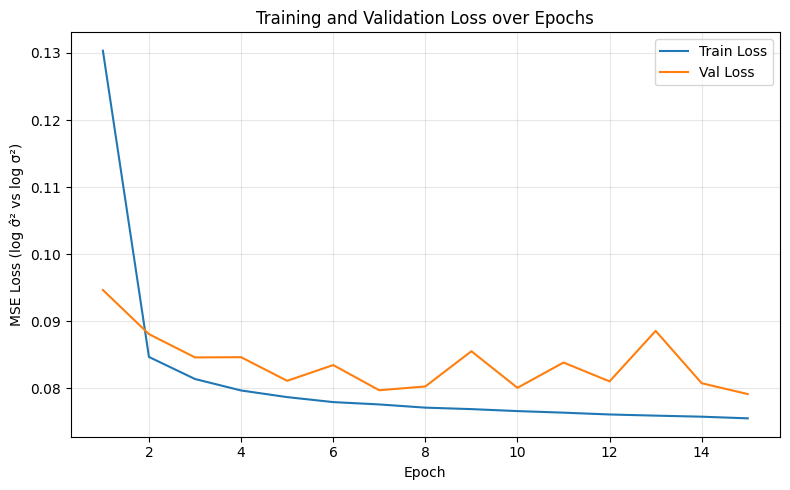


STEP 6: MULTI-SERIES PARAMETER VISUALIZATION (VALIDATION)

[Multi-Series] Variance prediction quality on validation set (scaled σ²):
  Val MSE: 5.5887e+00
  Val MAE: 1.6951e-01
  Val R² : 0.9801

[Multi-Series] Parameter error summary (NN, validation):
  Mean |ω_hat - ω|      : 1.6918e-02
  Mean |α_hat - α|      : 1.2403e-01
  Mean |β_hat - β|      : 1.2627e-01
  Mean rel error ω      : 68.21%
  Mean rel error α      : 86.79%
  Mean rel error β      : 39.99%

[Comparison: NN vs arch_model vs true parameters]
  Mean |ω̂_NN   - ω|   : 1.6918e-02
  Mean |ω̂_arch - ω|   : 1.5758e-02
  Mean |α̂_NN   - α|   : 1.2403e-01
  Mean |α̂_arch - α|   : 4.4333e-02
  Mean |β̂_NN   - β|   : 1.2627e-01
  Mean |β̂_arch - β|   : 4.1885e-02

  Persistence C = α+β :
    Mean true C        : 0.9451
    Mean NN   Ĉ       : 0.9262
    Mean arch Ĉ       : 0.9420
    MAE C NN           : 2.6035e-02
    MAE C arch         : 2.5504e-02
Saved NN vs ARCH parameter error comparison to 'garch_nn_vs_arch_param_error

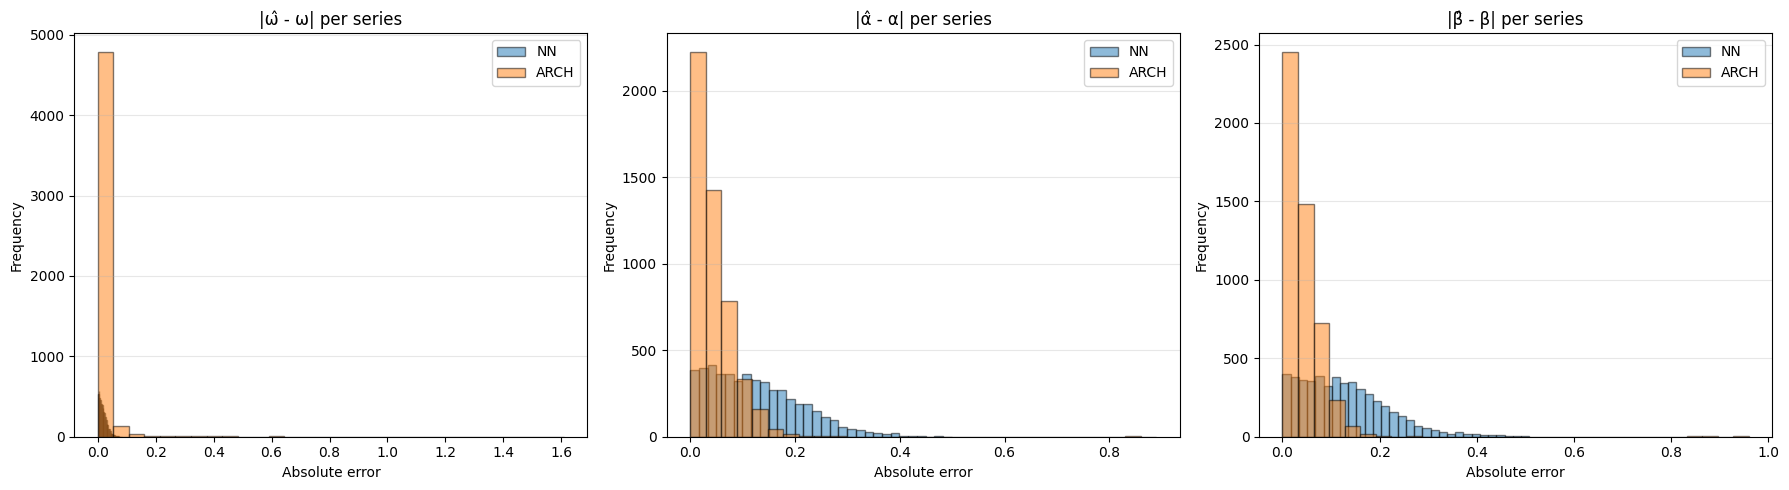

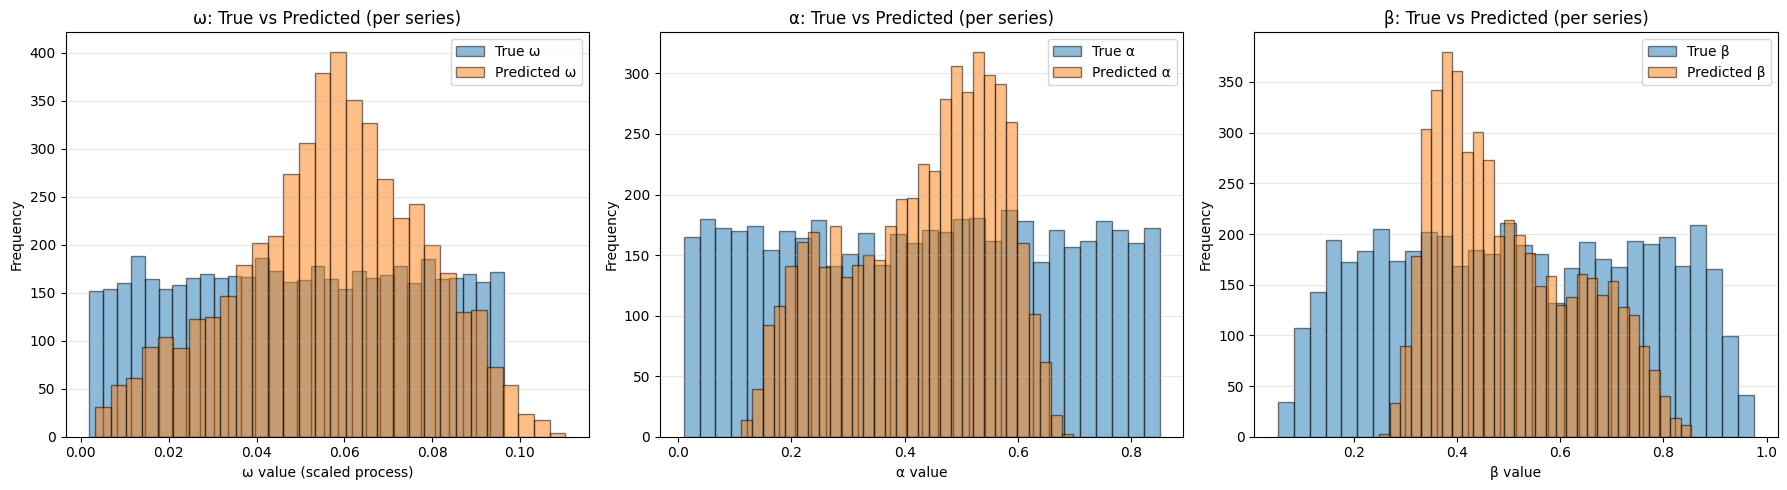

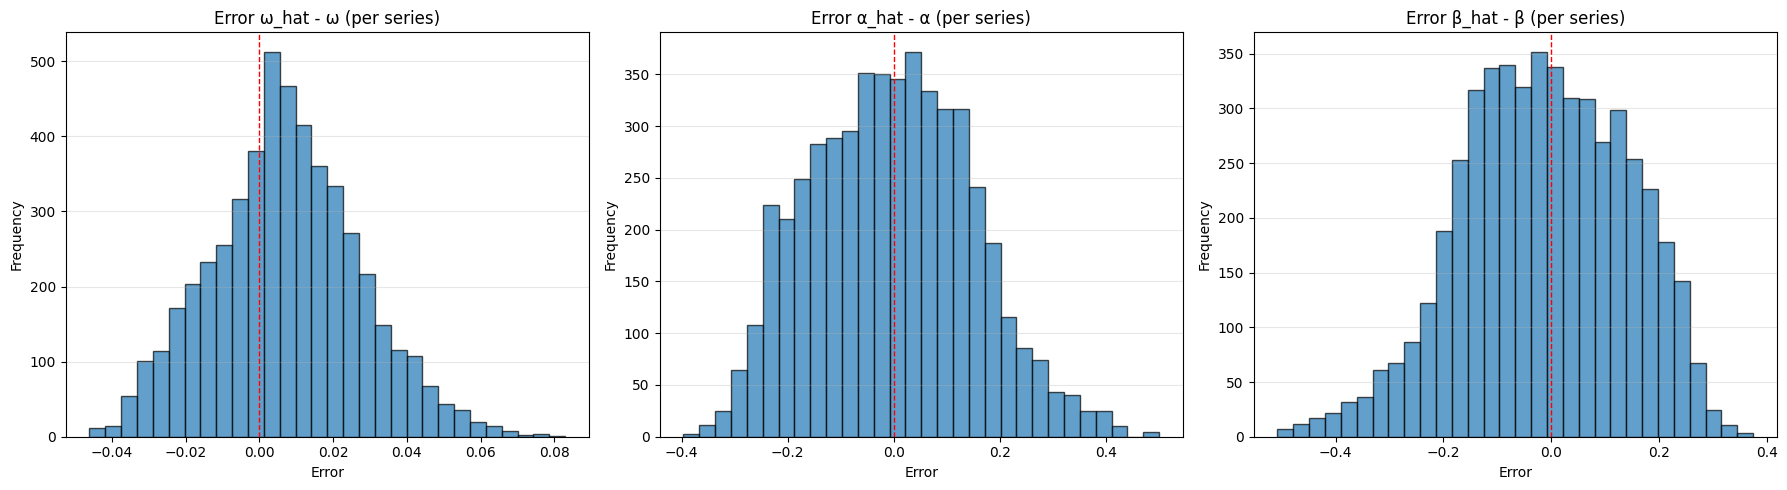

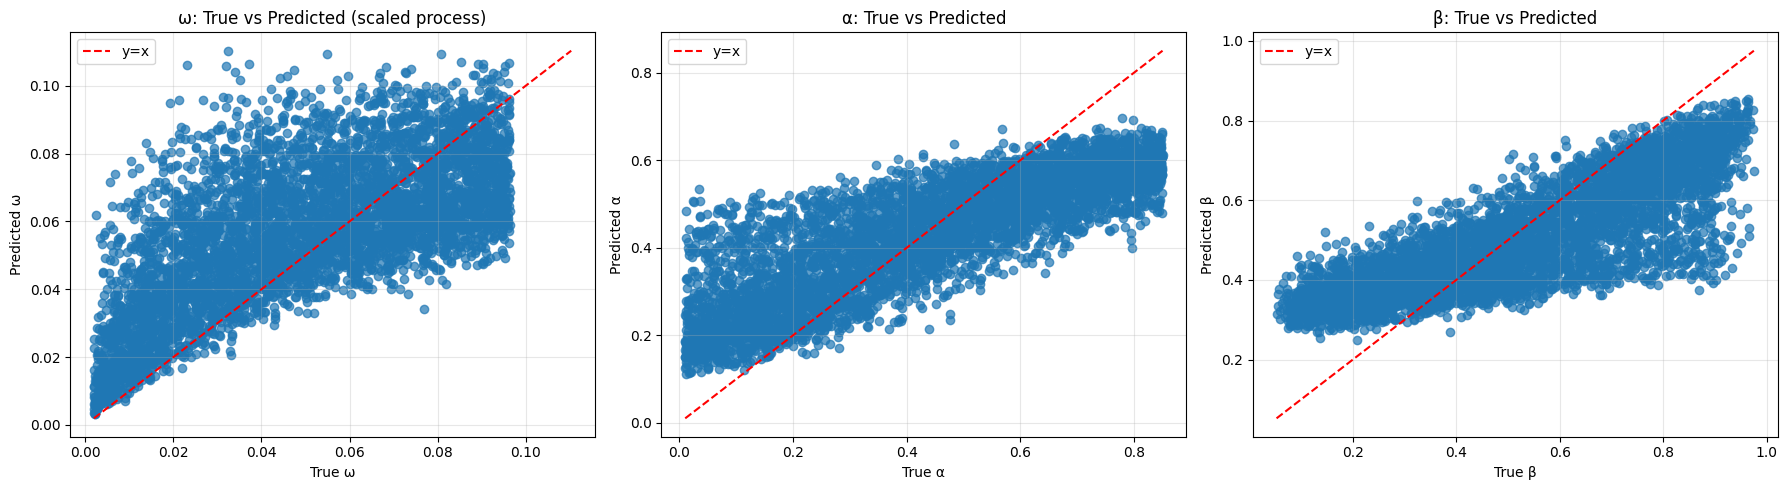

Mean true α+β : 0.9451201670244245
Mean pred α+β : 0.9261876655966044
Min pred α+β  : 0.8685037195682526
Max pred α+β  : 0.9833950996398926

Multi-series metrics summary (validation, scaled σ²):
  val_mse: 5.588693
  val_mae: 0.169512
  val_r2: 0.980140
  omega_abs_err_mean: 0.016918
  alpha_abs_err_mean: 0.124029
  beta_abs_err_mean: 0.126272

Key OOS metric: R² on σ²_t+1 (validation, scaled) = 0.9801

[Forecast comparison on validation set (σ²_{t+1}, standardised process)]
  NN–GARCH   MSE = 5.5887e+00, MAE = 1.6951e-01, R² = 0.9801
  GARCH(1,1) MSE = 2.3226e+00, MAE = 9.6959e-02, R² = 0.9918
  GARCH(1,1) MSE on σ_(t+1) (std): 8.3840e-03
Saved NN vs ARCH forecast comparison to 'sigma2_forecast_nn_vs_arch_series0.png'


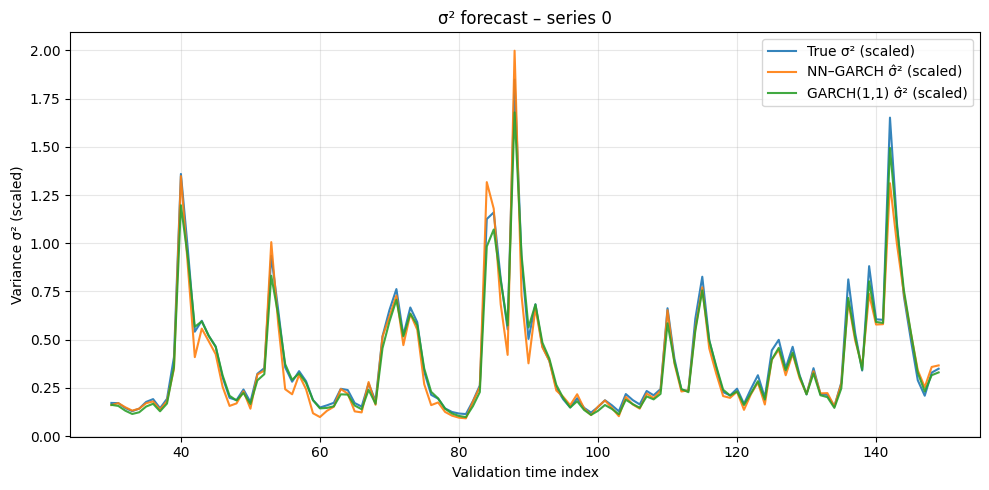


STEP 7: α TRUE vs α PRED (TRAIN / VAL / TEST)
Saved Train α true vs predicted scatter to 'alpha_true_vs_pred_train.png'


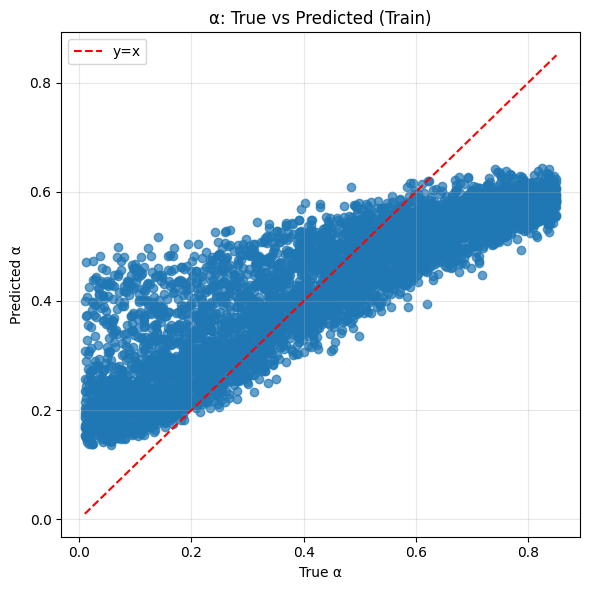

Saved Validation α true vs predicted scatter to 'alpha_true_vs_pred_val.png'


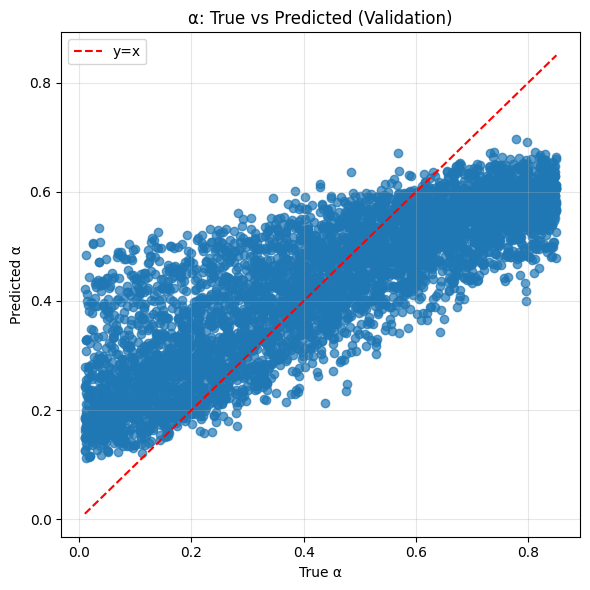

Saved Test α true vs predicted scatter to 'alpha_true_vs_pred_test.png'


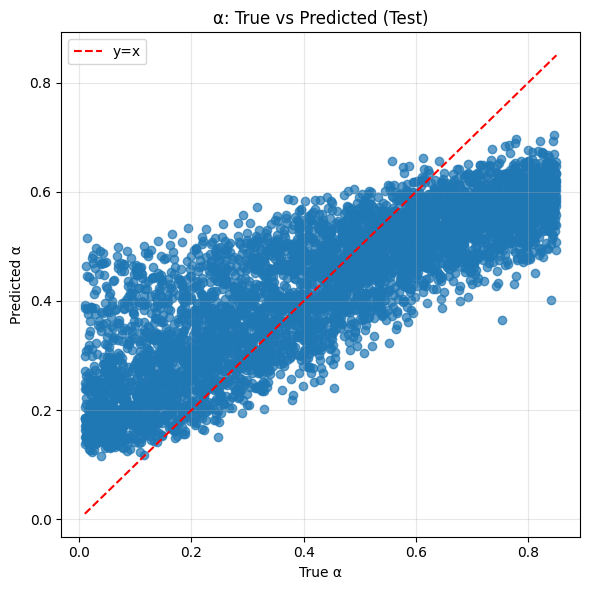


EXPERIMENT COMPLETED SUCCESSFULLY!

Key Achievements:
  ✓ NN successfully learned to approximate (scaled) GARCH parameters across many series
  ✓ Dynamic volatility layer captures time-varying variance on standardised returns
  ✓ Model maintains stationarity constraint (α + β < 1) via parameter projection
  ✓ Loss trained on log-variance log(σ²) for more stable optimisation

Generated Files:
  - training_curves.png
  - garch_multi_param_distributions.png
  - garch_multi_param_errors.png
  - garch_multi_param_scatter.png
  - garch_nn_vs_arch_param_errors.png
  - sigma2_forecast_nn_vs_arch_series0.png
  - alpha_true_vs_pred_train.png
  - alpha_true_vs_pred_val.png
  - alpha_true_vs_pred_test.png
  - best_garch_model_interpolation.pt (saved model weights)


In [ ]:


# ============================================================================
# 10. MAIN EXAMPLE WITH FULL WORKFLOW
# ============================================================================

def main():
    """
    Complete workflow: Generate MULTI-SERIES GARCH data, train hybrid NN-GARCH model,
    and perform comprehensive multi-series evaluation.
    """
    print("=" * 80)
    print("HYBRID GARCH(1,1) + NEURAL NETWORK MODEL")
    print("Dynamic Volatility Layer with Parameter Learning (MULTI-SERIES)")
    print("Standardised returns + log-variance training")
    print("=" * 80)
    print()

    # ========== Configuration ==========
    N_SERIES   = 5000
    N_SAMPLES  = 1000
    TRAIN_SPLIT = 0.7
    VAL_SPLIT   = 0.15   # reste pour test éventuel
    TEST_SPLIT  = 1.0 - TRAIN_SPLIT - VAL_SPLIT

    # Sample GARCH parameters for each series (true parameters - ORIGINAL SCALE)
    TRUE_OMEGAS = np.random.uniform(0.001, 0.05, size=N_SERIES)
    TRUE_ALPHAS = np.random.uniform(0.01, 0.85,  size=N_SERIES)
    TRUE_BETAS  = 0.99 - TRUE_ALPHAS - np.random.uniform(0.0, 0.09,  size=N_SERIES)

    print(f"Sampling random GARCH parameters for {N_SERIES} series...")
    print("Example (first 5):")
    for j in range(5):
        print(
            f"Series {j}: "
            f"omega={TRUE_OMEGAS[j]:.4f}, "
            f"alpha={TRUE_ALPHAS[j]:.4f}, "
            f"beta={TRUE_BETAS[j]:.4f}, "
            f"alpha+beta={TRUE_ALPHAS[j] + TRUE_BETAS[j]:.4f}"
        )

    # Model configuration
    WINDOW_SIZE = 30
    HIDDEN_DIM  = 128

    # Training configuration
    BATCH_SIZE    = 2048
    N_EPOCHS      = 15
    LEARNING_RATE = 1e-3

    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\nUsing device: {device}\n")

    # ========== Step 1: Generate GARCH Data Series ==========
    all_returns_list   = []
    all_variances_list = []

    for j in range(N_SERIES):
        generator = GARCHGenerator(
            omega=float(TRUE_OMEGAS[j]),
            alpha=float(TRUE_ALPHAS[j]),
            beta=float(TRUE_BETAS[j]),
            n_samples=N_SAMPLES,
            seed=42 + j  # different seed per series
        )

        returns_j, variances_j = generator.generate_series()
        all_returns_list.append(returns_j)
        all_variances_list.append(variances_j)

    # Stack into tensors: shape [N_SERIES, N_SAMPLES]
    all_returns   = torch.stack(all_returns_list,   dim=0)  # ORIGINAL scale
    all_variances = torch.stack(all_variances_list, dim=0)  # ORIGINAL σ²

    print(f"\nGenerated {N_SERIES} GARCH series:")
    print(f"  all_returns shape:   {all_returns.shape}")   # (N_SERIES, 5000)
    print(f"  all_variances shape: {all_variances.shape}") # (N_SERIES, 5000)

    # ========== Step 1bis: Global standardisation of returns + rescale σ² ==========
    # We standardise returns globally: r_std = (r - mean) / std
    # Then σ²_std = σ² / std^2
    mean_r = all_returns.mean()
    std_r  = all_returns.std()
    std_r_f = float(std_r)

    all_returns = (all_returns - mean_r) / (std_r + 1e-8)
    all_variances = all_variances / ((std_r + 1e-8) ** 2)

    print(f"\nStandardised returns globally:")
    print(f"  mean ≈ {float(all_returns.mean()):.4f}, std ≈ {float(all_returns.std()):.4f}")
    print(f"  Scale factor used (std of original returns): {std_r_f:.4f}")

    # On the standardised process, the true parameters become:
    # ω' = ω / std^2, α' = α, β' = β
    TRUE_OMEGAS_SCALED = TRUE_OMEGAS / (std_r_f ** 2)
    TRUE_ALPHAS_SCALED = TRUE_ALPHAS
    TRUE_BETAS_SCALED  = TRUE_BETAS

    # ========== Step 2: Create Train/Val/Test datasets from ALL series ==========
    train_len = int(TRAIN_SPLIT * N_SAMPLES)
    val_len   = int(VAL_SPLIT   * N_SAMPLES)
    test_len  = N_SAMPLES - train_len - val_len

    train_returns   = all_returns[:, :train_len]                       # [N_SERIES, train_len]
    train_variances = all_variances[:, :train_len]

    val_returns     = all_returns[:, train_len:train_len + val_len]    # [N_SERIES, val_len]
    val_variances   = all_variances[:, train_len:train_len + val_len]

    test_returns    = all_returns[:, train_len + val_len:]             # [N_SERIES, test_len]
    test_variances  = all_variances[:, train_len + val_len:]

    print(f"\nTrain time length: {train_len}")
    print(f"Val time length:   {val_len}")
    print(f"Test time length:  {test_len}")

    # ========= 2b. Fit classical GARCH(1,1) with arch_model on TRAIN only =========
    # NOTE: arch_model sees STANDARDISED returns here.
    garch_omega_hat = np.zeros(N_SERIES)
    garch_alpha_hat = np.zeros(N_SERIES)
    garch_beta_hat  = np.zeros(N_SERIES)

    for j in range(N_SERIES):
        r_train = train_returns[j].numpy()   # shape [train_len], standardised
        am = arch_model(
        r_train,
        vol='GARCH',
        p=1,
        q=1,
        mean='Zero',
        dist='normal',
        rescale=False,    # IMPORTANT si tu veux éviter que ARCH refasse son propre rescale
        )

        res = am.fit(disp='off')

        garch_omega_hat[j] = res.params['omega']
        garch_alpha_hat[j] = res.params['alpha[1]']
        garch_beta_hat[j]  = res.params['beta[1]']

    #If PB with ARCH alpha + beta > 1 we can see here
    C_true = TRUE_ALPHAS_SCALED + TRUE_BETAS_SCALED
    C_arch = garch_alpha_hat + garch_beta_hat

    print("True C = α+β (mean/min/max):",
          C_true.mean(), C_true.min(), C_true.max())
    print("ARCH Ĉ = α̂+β̂ (mean/min/max):",
          C_arch.mean(), C_arch.min(), C_arch.max())

    print("omega true (scaled) mean/min/max:",
          TRUE_OMEGAS_SCALED.mean(), TRUE_OMEGAS_SCALED.min(), TRUE_OMEGAS_SCALED.max())
    print("omega_hat ARCH mean/min/max:",
          garch_omega_hat.mean(), garch_omega_hat.min(), garch_omega_hat.max())

    # ---------- Projection des paramètres ARCH dans le même domaine que le générateur ----------
    # Domaine de persistance dans tes données synthétiques
    C_min, C_max = C_true.min(), C_true.max()   # typiquement ~0.90 et ~0.99

    C_hat = garch_alpha_hat + garch_beta_hat   # α̂ + β̂

    # On clip Ĉ dans [C_min, C_max]
    C_clipped = np.clip(C_hat, C_min, C_max)

    # On rescale α̂ et β̂ pour que α̂+β̂ devienne C_clipped
    scale = C_clipped / (C_hat + 1e-8)
    garch_alpha_hat *= scale
    garch_beta_hat  *= scale

    # Par curiosité, on regarde après projection
    C_arch_proj = garch_alpha_hat + garch_beta_hat
    print("ARCH Ĉ after projection (mean/min/max):",
          C_arch_proj.mean(), C_arch_proj.min(), C_arch_proj.max())


    # ========= Step 2c: Build PyTorch datasets and loaders =========

    train_dataset = MultiGARCHDataset(train_returns, train_variances, WINDOW_SIZE)
    val_dataset   = MultiGARCHDataset(val_returns,   val_variances,   WINDOW_SIZE)
    test_dataset  = MultiGARCHDataset(test_returns,  test_variances,  WINDOW_SIZE)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=4, pin_memory=True)
    val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=4, pin_memory=True)

    print(f"\nTrain samples: {len(train_dataset)}")
    print(f"Val samples:   {len(val_dataset)}")
    print(f"Test samples:  {len(test_dataset)}")
    print(f"Train batches: {len(train_loader)}")
    print(f"Val batches:   {len(val_loader)}")

    # ========== Step 3: Initialize Model ==========
    print("\n" + "=" * 80)
    print("STEP 3: INITIALIZING HYBRID MODEL")
    print("=" * 80)

    model = HybridGARCHModel(input_seq_len=WINDOW_SIZE, hidden_dim=HIDDEN_DIM)
    model = model.to(device)

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model architecture:")
    print(f"  Parameter Network: Conv1d → MLP → (ω, α, β)")
    print(f"  Volatility Layer:  GARCH(1,1) recursion")
    print(f"  Total trainable parameters: {total_params:,}")

    print(f"\nModel structure:")
    print(model)

    # ========== Step 4: Train Model ==========
    print("\n" + "=" * 80)
    print("STEP 4: TRAINING HYBRID MODEL")
    print("=" * 80)
    print(f"Epochs: {N_EPOCHS}")
    print(f"Learning rate: {LEARNING_RATE}")
    print(f"Optimizer: Adam with weight decay")
    print(f"Loss: MSE between predicted and true log-variance log(σ²)")
    print()

    history = train_hybrid_garch(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        n_epochs=N_EPOCHS,
        learning_rate=LEARNING_RATE,
        device=device,
        checkpoint_path="best_garch_model_interpolation.pt",  # ← ici
        load_best=True,
    )

    # ======= SAUVEGARDE DU MODELE PRE-ENTRAINE SUR DONNEES SYNTHETIQUES =======
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "window_size": WINDOW_SIZE,
        "hidden_dim": HIDDEN_DIM,
        # Très important pour réutiliser le même scaling plus tard
        "mean_r": float(mean_r),
        "std_r": float(std_r),
        "n_series": N_SERIES,
        "n_samples": N_SAMPLES,
    }

    torch.save(checkpoint, "hybrid_garch_pretrained_synth.pt")
    print("\nSaved pretrained synthetic model to 'hybrid_garch_pretrained_synth.pt'")

    # ========== Step 5: Global Loss Summary ==========
    print("\n" + "=" * 80)
    print("STEP 5: GLOBAL TRAINING SUMMARY")
    print("=" * 80)

    print("\nLoss Summary (log-variance MSE):")
    print(f"  Initial train loss: {history['train_loss'][0]:.6f}")
    print(f"  Final train loss:   {history['train_loss'][-1]:.6f}")
    print(f"  Final val loss:     {history['val_loss'][-1]:.6f}")
    print(f"  Loss reduction:     {(1 - history['train_loss'][-1] / history['train_loss'][0]) * 100:.2f}%")

    # ========== Step 5bis: Plot Training Curves ==========
    plot_training_curves(history, save_path="training_curves.png")

    # ========== Step 6: Multi-Series Visualizations (VALIDATION) ==========
    print("\n" + "=" * 80)
    print("STEP 6: MULTI-SERIES PARAMETER VISUALIZATION (VALIDATION)")
    print("=" * 80)

    multi_metrics = create_visualizations_multi(
        model=model,
        val_dataset=val_dataset,         # MultiGARCHDataset (std scale)
        true_omegas=TRUE_OMEGAS_SCALED,  # true params on std process
        true_alphas=TRUE_ALPHAS_SCALED,
        true_betas=TRUE_BETAS_SCALED,
        device=device,
        batch_size=BATCH_SIZE,
        garch_omegas=garch_omega_hat,
        garch_alphas=garch_alpha_hat,
        garch_betas=garch_beta_hat,
    )

    print("\nMulti-series metrics summary (validation, scaled σ²):")
    for k, v in multi_metrics.items():
        print(f"  {k}: {v:.6f}")
    print(f"\nKey OOS metric: R² on σ²_t+1 (validation, scaled) = {multi_metrics['val_r2']:.4f}")

    # ========== Step 6bis: Forecast comparison NN–GARCH vs classical GARCH(1,1) ==========
    # Tout en numpy pour la comparaison (sur STANDARDISED process)
    all_returns_np   = all_returns.numpy()      # [N_SERIES, N_SAMPLES], std
    all_variances_np = all_variances.numpy()    # [N_SERIES, N_SAMPLES], σ² std

    # 1) Recalcule σ̂²_t pour le GARCH(1,1) estimé par arch_model
    arch_sigma2_hat = np.zeros_like(all_returns_np)  # même shape

    for j in range(N_SERIES):
        arch_sigma2_hat[j, :] = compute_garch_variance_from_params(
            returns=all_returns_np[j, :],
            omega=garch_omega_hat[j],
            alpha=garch_alpha_hat[j],
            beta=garch_beta_hat[j],
        )

    # 2) On extrait le bloc validation (mêmes dates que val_dataset)
    arch_val_sigma2 = arch_sigma2_hat[:, train_len:train_len + val_len]       # [N_SERIES, val_len]
    true_val_sigma2 = all_variances_np[:, train_len:train_len + val_len]      # [N_SERIES, val_len]

    # 3) On se met exactement sur les mêmes indices que le dataset de validation:
    #    target = σ²_{t+WINDOW_SIZE} pour une fenêtre [t, ..., t+WINDOW_SIZE-1]
    targets_flat = []
    arch_flat    = []

    for j in range(N_SERIES):
        for t in range(val_len - WINDOW_SIZE):
            idx = t + WINDOW_SIZE
            targets_flat.append(true_val_sigma2[j, idx])      # vraie σ²_t+1 (std)
            arch_flat.append(arch_val_sigma2[j, idx])         # σ̂²_t+1 GARCH (std)

    targets_flat = np.array(targets_flat)
    arch_flat    = np.array(arch_flat)

    # 4) Metrics pour le GARCH(1,1) classique sur σ² (std scale)
    mse_arch = np.mean((arch_flat - targets_flat)**2)
    mae_arch = np.mean(np.abs(arch_flat - targets_flat))
    r2_arch  = np.corrcoef(targets_flat, arch_flat)[0, 1]**2

    # 5) Comparaison imprimée NN vs ARCH
    print("\n[Forecast comparison on validation set (σ²_{t+1}, standardised process)]")
    print(f"  NN–GARCH   MSE = {multi_metrics['val_mse']:.4e}, "
          f"MAE = {multi_metrics['val_mae']:.4e}, "
          f"R² = {multi_metrics['val_r2']:.4f}")
    print(f"  GARCH(1,1) MSE = {mse_arch:.4e}, "
          f"MAE = {mae_arch:.4e}, "
          f"R² = {r2_arch:.4f}")

    # (Optionnel) Comparaison aussi sur σ_t (= sqrt(σ²_t))
    sigma_true = np.sqrt(np.clip(targets_flat, 1e-12, None))
    sigma_arch = np.sqrt(np.clip(arch_flat,    1e-12, None))
    mse_sigma_arch = np.mean((sigma_arch - sigma_true)**2)
    print(f"  GARCH(1,1) MSE on σ_(t+1) (std): {mse_sigma_arch:.4e}")

    # ========== Step 6ter: Visual comparison of σ² forecasts on one series ==========
    plot_forecast_comparison_nn_vs_arch(
        model=model,
        val_returns=val_returns,             # torch.Tensor [N_SERIES, val_len] std
        true_val_sigma2=true_val_sigma2,     # np.ndarray   [N_SERIES, val_len] std
        arch_val_sigma2=arch_val_sigma2,     # np.ndarray   [N_SERIES, val_len] std
        window_size=WINDOW_SIZE,
        device=device,
        series_idx=0,                        # change to 1,2,... for other series
        save_path="sigma2_forecast_nn_vs_arch_series0.png",
    )

    # ========== Step 7: α_true vs α_pred plots for TRAIN / VAL / TEST ==========
    print("\n" + "=" * 80)
    print("STEP 7: α TRUE vs α PRED (TRAIN / VAL / TEST)")
    print("=" * 80)

    alpha_hat_train = collect_alpha_per_series(model, train_dataset, device, batch_size=BATCH_SIZE)
    alpha_hat_val   = collect_alpha_per_series(model, val_dataset,   device, batch_size=BATCH_SIZE)
    alpha_hat_test  = collect_alpha_per_series(model, test_dataset,  device, batch_size=BATCH_SIZE)

    # TRUE_ALPHAS_SCALED == TRUE_ALPHAS (α invariant to scale)
    plot_alpha_true_vs_pred(TRUE_ALPHAS_SCALED, alpha_hat_train,
                            "Train", "alpha_true_vs_pred_train.png")
    plot_alpha_true_vs_pred(TRUE_ALPHAS_SCALED, alpha_hat_val,
                            "Validation", "alpha_true_vs_pred_val.png")
    plot_alpha_true_vs_pred(TRUE_ALPHAS_SCALED, alpha_hat_test,
                            "Test", "alpha_true_vs_pred_test.png")

    # ========== Summary ==========
    print("\n" + "=" * 80)
    print("EXPERIMENT COMPLETED SUCCESSFULLY!")
    print("=" * 80)
    print("\nKey Achievements:")
    print("  ✓ NN successfully learned to approximate (scaled) GARCH parameters across many series")
    print("  ✓ Dynamic volatility layer captures time-varying variance on standardised returns")
    print("  ✓ Model maintains stationarity constraint (α + β < 1) via parameter projection")
    print("  ✓ Loss trained on log-variance log(σ²) for more stable optimisation")
    print("\nGenerated Files:")
    print("  - training_curves.png")
    print("  - garch_multi_param_distributions.png")
    print("  - garch_multi_param_errors.png")
    print("  - garch_multi_param_scatter.png")
    print("  - garch_nn_vs_arch_param_errors.png")
    print("  - sigma2_forecast_nn_vs_arch_series0.png")
    print("  - alpha_true_vs_pred_train.png")
    print("  - alpha_true_vs_pred_val.png")
    print("  - alpha_true_vs_pred_test.png")
    print("  - best_garch_model_interpolation.pt (saved model weights)")
    print("=" * 80)



main()


# 20 fiinancial stocks

In [ ]:
import yfinance as yf

def download_log_returns_for_tickers(
    tickers,
    n_series_target=1000,
    n_samples=1000,
    verbose=True,
):
    """
    Télécharge des prix daily via yfinance et renvoie un tensor
    [N_SERIES, N_SAMPLES] de log-returns.

    - n_series_target : nombre max de séries qu'on veut (1000 si possible)
    - n_samples       : longueur en temps (1000 points de return)
    """
    all_returns = []
    used_tickers = []

    for tic in tickers:
        if verbose:
            print(f"Downloading {tic} ...")

        try:
            data = yf.download(
                tic,
                period="max",          # toute l'historique
                interval="1d",
                auto_adjust=True,      # prix ajustés dividendes / splits
                progress=False,
            )
            close = data["Close"].dropna()
            if len(close) < n_samples + 1:
                if verbose:
                    print(f"  -> not enough data: {len(close)} days")
                continue

            # On garde les (n_samples+1) derniers prix et on fait les log-returns
            close = close[-(n_samples + 1):]
            prices = close.values
            r = np.log(prices[1:] / prices[:-1])   # longueur n_samples

            all_returns.append(torch.tensor(r, dtype=torch.float32))
            used_tickers.append(tic)

            if len(all_returns) >= n_series_target:
                break

        except Exception as e:
            if verbose:
                print(f"  -> error for {tic}: {e}")
            continue

    if len(all_returns) == 0:
        raise RuntimeError("No valid series downloaded from yfinance.")

    all_returns = torch.stack(all_returns, dim=0)  # [N_SERIES, N_SAMPLES]
    return all_returns, used_tickers




from torch.utils.data import DataLoader

def evaluate_nn_on_dataset(model, dataset, device, batch_size=256):
    """
    Calcule MSE / MAE / R² entre σ̂² (NN) et la "variance vraie"
    prise ici comme la target du dataset (ex: r_t^2 ou σ² synthétique).
    """
    model.eval()
    loader = DataLoader(dataset, batch_size=batch_size,
                        shuffle=False, num_workers=0)

    preds = []
    targets = []

    with torch.no_grad():
        for batch_returns, batch_target_var in loader:
            batch_returns = batch_returns.to(device)
            batch_target_var = batch_target_var.to(device)

            pred_var, _, _, _ = model(batch_returns)

            preds.append(pred_var.cpu().numpy())
            targets.append(batch_target_var.cpu().numpy())

    import numpy as np
    preds = np.concatenate(preds)
    targets = np.concatenate(targets)

    mse = np.mean((preds - targets)**2)
    mae = np.mean(np.abs(preds - targets))
    corr = np.corrcoef(targets, preds)[0, 1]
    r2 = float(corr**2) if np.isfinite(corr) else 0.0

    return {"mse": float(mse), "mae": float(mae), "r2": r2}



def evaluate_arch_on_validation(
    arch_sigma2_hat: np.ndarray,
    all_returns_np: np.ndarray,
    train_len: int,
    val_len: int,
    window_size: int,
):
    """
    Évalue le GARCH(1,1) classique sur le segment de validation.

    arch_sigma2_hat : [N_SERIES, N_SAMPLES]  σ̂²_t (std) venant de compute_garch_variance_from_params
    all_returns_np  : [N_SERIES, N_SAMPLES]  rendements standardisés
                     (on utilise r_t^2 comme proxy de la variance vraie).
    """
    N_SERIES, N_SAMPLES = all_returns_np.shape

    # Indices temporels du bloc validation
    val_start = train_len
    val_end   = train_len + val_len

    # Proxy de la variance "vraie" : r_t^2 (déjà standardisé)
    true_val_sigma2 = (all_returns_np[:, val_start:val_end] ** 2)
    arch_val_sigma2 = arch_sigma2_hat[:, val_start:val_end]

    # On se met sur les mêmes t que le dataset de validation :
    # target = σ²_{t+WINDOW_SIZE} pour fenêtre [t, ..., t+WINDOW_SIZE-1]
    targets_flat = []
    arch_flat    = []

    for j in range(N_SERIES):
        for t in range(val_len - window_size):
            idx = t + window_size
            targets_flat.append(true_val_sigma2[j, idx])   # "vraie" σ²_{t+1} (proxy)
            arch_flat.append(arch_val_sigma2[j, idx])      # σ̂²_{t+1} du GARCH

    targets_flat = np.array(targets_flat)
    arch_flat    = np.array(arch_flat)

    # Metrics
    mse = np.mean((arch_flat - targets_flat) ** 2)
    mae = np.mean(np.abs(arch_flat - targets_flat))

    if np.var(arch_flat) > 0 and np.var(targets_flat) > 0:
        r2 = np.corrcoef(targets_flat, arch_flat)[0, 1] ** 2
    else:
        r2 = 0.0

    # En bonus : métrique sur σ_t (écart-type) au lieu de σ²_t
    sigma_true = np.sqrt(np.clip(targets_flat, 1e-12, None))
    sigma_arch = np.sqrt(np.clip(arch_flat,    1e-12, None))
    mse_sigma  = np.mean((sigma_arch - sigma_true) ** 2)

    return {
        "mse": float(mse),
        "mae": float(mae),
        "r2":  float(r2),
        "mse_sigma": float(mse_sigma),
    }


In [ ]:
import yfinance as yf

# =====================================================================
# MAIN : évaluer le modèle pré-entraîné sur données financières réelles
# =====================================================================
def main_eval_pretrained_on_real():
    """
    Évalue le modèle hybride GARCH(1,1)+NN pré-entraîné sur données synthétiques
    directement sur des séries financières réelles (yfinance), SANS fine-tuning.
    """
    print("=" * 80)
    print("EVALUATION OF PRETRAINED HYBRID GARCH(1,1) + NN ON REAL MARKET DATA")
    print("No fine-tuning, just forward on yfinance daily log-returns")
    print("=" * 80)

    # ----------------- Device -----------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}\n")

    # ----------------- Charger le checkpoint synthétique -----------------
    ckpt_path = "hybrid_garch_pretrained_synth.pt"
    checkpoint = torch.load(ckpt_path, map_location=device)
    print(f"Loaded checkpoint '{ckpt_path}'")

    window_size_ckpt = checkpoint["window_size"]
    hidden_dim_ckpt  = checkpoint["hidden_dim"]
    n_samples_ckpt   = checkpoint["n_samples"]
    mean_r_synth     = checkpoint["mean_r"]
    std_r_synth      = checkpoint["std_r"]

    print(f"  window_size = {window_size_ckpt}")
    print(f"  hidden_dim  = {hidden_dim_ckpt}")
    print(f"  n_samples   = {n_samples_ckpt}")
    print(f"  mean_r_synth = {mean_r_synth:.4e}, std_r_synth = {std_r_synth:.4e}")

    # ----------------- Reconstruire le modèle -----------------
    model = HybridGARCHModel(input_seq_len=window_size_ckpt,
                             hidden_dim=hidden_dim_ckpt).to(device)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    # ----------------- Config des données réelles -----------------
    TARGET_N_SERIES = 200          # pas besoin de 1000 pour tester
    N_SAMPLES       = n_samples_ckpt   # on garde la même longueur temporelle

    # Tickers pour le test
    TICKERS = [
        "^GSPC",  # S&P 500
        "AAPL", "MSFT", "GOOGL", "AMZN", "META",
        "TSLA", "NVDA", "JPM", "XOM",
        "OR.PA", "AIR.PA", "MC.PA", "BNP.PA",
        # tu peux en rajouter
    ]

    # ----------------- 1) Télécharger les log-returns -----------------
    all_returns_raw, used_tickers = download_log_returns_for_tickers(
        TICKERS,
        n_series_target=TARGET_N_SERIES,
        n_samples=N_SAMPLES,
        verbose=True,
    )

    # all_returns_raw est déjà un torch.Tensor de forme [N_SERIES, N_SAMPLES]
    print(f"\nGot {all_returns_raw.shape[0]} real series from yfinance.")
    print("First 10 tickers used:", used_tickers[:10])

    # On s'assure de la bonne forme (2D) et du bon type
    # On s'assure de la bonne forme (2D) et du bon type
    assert isinstance(all_returns_raw, torch.Tensor)

    # Si la forme est [N_SERIES, N_SAMPLES, 1], on squeeze la dernière dim
    if all_returns_raw.dim() == 3 and all_returns_raw.size(-1) == 1:
        all_returns_raw = all_returns_raw.squeeze(-1)   # -> [N_SERIES, N_SAMPLES]

    assert all_returns_raw.dim() == 2, f"Expected 2D [N_SERIES, N_SAMPLES], got {all_returns_raw.shape}"


    # ----------------- 2) Standardisation avec les stats synthétiques -----------------
    all_returns_real = (all_returns_raw - mean_r_synth) / (std_r_synth + 1e-8)
    all_variances_real = all_returns_real ** 2  # proxy σ² = r_std^2

    print("\nStandardised real returns with synthetic stats:")
    print(f"  mean ≈ {float(all_returns_real.mean()):.4f}, std ≈ {float(all_returns_real.std()):.4f}")
    print("Shape of all_returns_real:", all_returns_real.shape)  # doit être [N_SERIES, N_SAMPLES]

    # ----------------- 3) Construire le dataset pour MultiGARCHDataset -----------------
    # ATTENTION : MultiGARCHDataset attend returns_mat 2D [n_series, series_len]
    dataset_real = MultiGARCHDataset(
        returns_mat=all_returns_real,
        variances_mat=all_variances_real,
        window_size=window_size_ckpt,
    )

    # On évalue juste sur tout le dataset (pas de split train/val ici)
    real_metrics = evaluate_nn_on_dataset(
        model=model,
        dataset=dataset_real,
        device=device,
        batch_size=256,
    )

    print("\nPerformance of pretrained NN–GARCH on real data (proxy var = r^2):")
    print(f"  MSE = {real_metrics['mse']:.4e}")
    print(f"  MAE = {real_metrics['mae']:.4e}")
    print(f"  R²  = {real_metrics['r2']:.4f}")
    print("\nEVALUATION COMPLETED.")
    print("=" * 80)


# Dans le notebook, tu appelles simplement :
main_eval_pretrained_on_real()


EVALUATION OF PRETRAINED HYBRID GARCH(1,1) + NN ON REAL MARKET DATA
No fine-tuning, just forward on yfinance daily log-returns
Using device: cuda



FileNotFoundError: [Errno 2] No such file or directory: 'hybrid_garch_pretrained_synth.pt'

# Fin-tunning

In [ ]:
def per_series_mse_arch(arch_val_sigma2: np.ndarray,
                        true_val_sigma2: np.ndarray) -> np.ndarray:
    """
    MSE par série pour GARCH(1,1) sur σ² (process standardisé).
    arch_val_sigma2, true_val_sigma2 : [N_SERIES, val_len]
    """
    return np.mean((arch_val_sigma2 - true_val_sigma2)**2, axis=1)


def per_series_mse_nn(model: nn.Module,
                      val_returns: torch.Tensor,
                      window_size: int,
                      device: torch.device) -> np.ndarray:
    """
    MSE( σ̂², r² ) par série sur la validation pour le NN-GARCH.
    """
    model.eval()
    N_SERIES, val_len = val_returns.shape
    mse_list = []

    with torch.no_grad():
        for j in range(N_SERIES):
            preds = []
            targets = []

            for t in range(val_len - window_size):
                window = val_returns[j, t:t+window_size].unsqueeze(0).unsqueeze(-1).to(device)
                pred_var, _, _, _ = model(window)
                preds.append(pred_var.item())

                idx = t + window_size
                target = (val_returns[j, idx]**2).item()   # r_std^2
                targets.append(target)

            preds   = np.array(preds)
            targets = np.array(targets)
            mse_j = np.mean((preds - targets)**2)
            mse_list.append(mse_j)

    return np.array(mse_list)


In [ ]:
import copy

# ================================================================
# FINE-TUNING DU MODELE PRE-ENTRAINE SUR DONNEES REELLES + ARCH
# ================================================================
def main_finetune_on_real():
    print("=" * 80)
    print("FINE-TUNING HYBRID GARCH(1,1) + NN ON REAL MARKET DATA")
    print("Start from synthetic pretraining, then adapt on yfinance data")
    print("=" * 80)

    # ----------------- Device -----------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}\n")

    # ----------------- Charger le checkpoint synthétique -----------------
    ckpt_path = "hybrid_garch_pretrained_synth.pt"
    checkpoint = torch.load(ckpt_path, map_location=device)
    print(f"Loaded checkpoint '{ckpt_path}'")

    window_size = checkpoint["window_size"]
    hidden_dim  = checkpoint["hidden_dim"]
    n_samples   = checkpoint["n_samples"]
    mean_r_synth = checkpoint["mean_r"]
    std_r_synth  = checkpoint["std_r"]

    print(f"  window_size = {window_size}")
    print(f"  hidden_dim  = {hidden_dim}")
    print(f"  n_samples   = {n_samples}")
    print(f"  mean_r_synth = {mean_r_synth:.4e}, std_r_synth = {std_r_synth:.4e}")

    # ----------------- Reconstruire le modèle & garder une copie pré-trainée -----------------
    model = HybridGARCHModel(input_seq_len=window_size,
                             hidden_dim=hidden_dim).to(device)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    # copie des poids pré-entraînés pour évaluer AVANT fine-tuning
    pretrained_state_dict = copy.deepcopy(model.state_dict())

    # ----------------- Config données réelles -----------------
    TARGET_N_SERIES = 200           # nombre max de séries
    N_SAMPLES       = n_samples     # on garde la même longueur temporelle
    TRAIN_SPLIT = 0.7
    VAL_SPLIT   = 0.15
    TEST_SPLIT  = 1.0 - TRAIN_SPLIT - VAL_SPLIT

    # Tickers pour le fine-tuning
    TICKERS = [
        "^GSPC",  # S&P 500
        "AAPL", "MSFT", "GOOGL", "AMZN", "META",
        "TSLA", "NVDA", "JPM", "XOM",
        "OR.PA", "AIR.PA", "MC.PA", "BNP.PA",
        # tu peux en rajouter
    ]

    # ----------------- 1) Télécharger log-returns réels -----------------
    all_returns_raw, used_tickers = download_log_returns_for_tickers(
        TICKERS,
        n_series_target=TARGET_N_SERIES,
        n_samples=N_SAMPLES,
        verbose=True,
    )

    print(f"\nGot {all_returns_raw.shape[0]} real series from yfinance.")
    print("First 10 tickers used:", used_tickers[:10])

    # S'assurer forme [N_SERIES, N_SAMPLES]
    assert isinstance(all_returns_raw, torch.Tensor)
    if all_returns_raw.dim() == 3 and all_returns_raw.size(-1) == 1:
        all_returns_raw = all_returns_raw.squeeze(-1)

    assert all_returns_raw.dim() == 2, f"Expected [N_SERIES, N_SAMPLES], got {all_returns_raw.shape}"
    N_SERIES = all_returns_raw.shape[0]

    # ----------------- 2) Standardisation avec les stats synthétiques -----------------
    all_returns = (all_returns_raw - mean_r_synth) / (std_r_synth + 1e-8)
    all_variances = all_returns ** 2   # proxy σ² = r_std^2

    print("\nStandardised real returns with synthetic stats:")
    print(f"  mean ≈ {float(all_returns.mean()):.4f}, std ≈ {float(all_returns.std()):.4f}")

    # ----------------- 3) Split temporel train / val / test -----------------
    train_len = int(TRAIN_SPLIT * N_SAMPLES)
    val_len   = int(VAL_SPLIT   * N_SAMPLES)
    test_len  = N_SAMPLES - train_len - val_len

    train_returns   = all_returns[:, :train_len]
    val_returns     = all_returns[:, train_len:train_len + val_len]
    test_returns    = all_returns[:, train_len + val_len:]

    train_variances = all_variances[:, :train_len]
    val_variances   = all_variances[:, train_len:train_len + val_len]
    test_variances  = all_variances[:, train_len + val_len:]

    print(f"\nTrain time length: {train_len}")
    print(f"Val time length:   {val_len}")
    print(f"Test time length:  {test_len}")

    train_dataset = MultiGARCHDataset(train_returns, train_variances, window_size)
    val_dataset   = MultiGARCHDataset(val_returns,   val_variances,   window_size)
    test_dataset  = MultiGARCHDataset(test_returns,  test_variances,  window_size)

    BATCH_SIZE_FT = 2048
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_FT,
                              shuffle=True, num_workers=4, pin_memory=True)
    val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE_FT,
                              shuffle=False, num_workers=4, pin_memory=True)

    print(f"\nTrain samples: {len(train_dataset)}")
    print(f"Val samples:   {len(val_dataset)}")
    print(f"Test samples:  {len(test_dataset)}")

    # ----------------- 4) Fitter GARCH(1,1) classique sur le segment TRAIN -----------------
    print("\nFitting classical GARCH(1,1) on TRAIN for each series...")
    garch_omega_hat = np.zeros(N_SERIES)
    garch_alpha_hat = np.zeros(N_SERIES)
    garch_beta_hat  = np.zeros(N_SERIES)

    for j in range(N_SERIES):
        r_train = train_returns[j].numpy()
        am = arch_model(
            r_train,
            vol='GARCH',
            p=1,
            q=1,
            mean='Zero',
            dist='normal',
            rescale=False,
        )
        res = am.fit(disp='off')
        garch_omega_hat[j] = res.params['omega']
        garch_alpha_hat[j] = res.params['alpha[1]']
        garch_beta_hat[j]  = res.params['beta[1]']

    print("Mean (alpha+beta) across series (ARCH):",
          float((garch_alpha_hat + garch_beta_hat).mean()))

    # Recalcule σ̂²_t pour ARCH sur toute la série standardisée
    all_returns_np = all_returns.numpy()
    arch_sigma2_hat = np.zeros_like(all_returns_np)
    for j in range(N_SERIES):
        arch_sigma2_hat[j, :] = compute_garch_variance_from_params(
            returns=all_returns_np[j, :],
            omega=garch_omega_hat[j],
            alpha=garch_alpha_hat[j],
            beta=garch_beta_hat[j],
        )

    # Perf ARCH sur la partie validation
    arch_val_metrics = evaluate_arch_on_validation(
        arch_sigma2_hat=arch_sigma2_hat,
        all_returns_np=all_returns_np,
        train_len=train_len,
        val_len=val_len,
        window_size=window_size,
    )

    # ----------------- 5) Eval du modèle PRE-ENTRAINE sur validation (AVANT FT) -----------------
    print("\nEvaluating PRETRAINED NN–GARCH on validation (before fine-tuning)...")
    model_pre = HybridGARCHModel(input_seq_len=window_size,
                                 hidden_dim=hidden_dim).to(device)
    model_pre.load_state_dict(pretrained_state_dict)
    metrics_pre = evaluate_nn_on_dataset(
        model=model_pre,
        dataset=val_dataset,
        device=device,
        batch_size=BATCH_SIZE_FT,
    )

    # ----------------- 6) FINE-TUNING sur données réelles -----------------
    print("\n" + "=" * 80)
    print("FINE-TUNING NN–GARCH ON REAL DATA")
    print("=" * 80)

    N_EPOCHS_FT      = 10
    LEARNING_RATE_FT = 1e-4

    history_ft = train_hybrid_garch(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        n_epochs=N_EPOCHS_FT,
        learning_rate=LEARNING_RATE_FT,
        device=device,
        checkpoint_path="best_garch_model_finetune_real.pt",
        load_best=True,
    )

    plot_training_curves(history_ft, save_path="training_curves_finetune_real.png")

    # ----------------- 7) Eval du modèle FINE-TUNE sur validation -----------------
    metrics_ft = evaluate_nn_on_dataset(
        model=model,
        dataset=val_dataset,
        device=device,
        batch_size=BATCH_SIZE_FT,
    )

    # ----------------- 8) PRINT COMPARAISON -----------------
    print("\n" + "=" * 80)
    print("COMPARISON ON VALIDATION (REAL DATA, proxy var = r^2)")
    print("=" * 80)
    print("Pretrained NN–GARCH:")
    print(f"  MSE = {metrics_pre['mse']:.4e}")
    print(f"  MAE = {metrics_pre['mae']:.4e}")
    print(f"  R²  = {metrics_pre['r2']:.4f}\n")

    print("Fine-tuned NN–GARCH:")
    print(f"  MSE = {metrics_ft['mse']:.4e}")
    print(f"  MAE = {metrics_ft['mae']:.4e}")
    print(f"  R²  = {metrics_ft['r2']:.4f}\n")

    print("GARCH(1,1) (ARCH library):")
    print(f"  MSE = {arch_val_metrics['mse']:.4e}")
    print(f"  MAE = {arch_val_metrics['mae']:.4e}")
    print(f"  R²  = {arch_val_metrics['r2']:.4f}")
    print(f"  MSE on σ_(t+1) = {arch_val_metrics['mse_sigma']:.4e}")

# ----------------- 9) PLOT FORECAST PRETRAIN vs FINETUNE vs ARCH sur 1 série -----------------
    val_start = train_len
    val_end   = train_len + val_len

    # proxy "true" σ² sur validation (r_std^2)
    true_val_sigma2 = (all_returns_np[:, val_start:val_end] ** 2)
    arch_val_sigma2 = arch_sigma2_hat[:, val_start:val_end]

    series_to_plot = 0  # change 0 -> 1,2,... pour regarder d'autres séries

    plot_forecast_pre_vs_ft_vs_arch(
        model_pre=model_pre,
        model_ft=model,
        val_returns=val_returns,          # torch.Tensor [N_SERIES, val_len]
        true_val_sigma2=true_val_sigma2,  # np.ndarray   [N_SERIES, val_len]
        arch_val_sigma2=arch_val_sigma2,  # np.ndarray   [N_SERIES, val_len]
        window_size=window_size,
        device=device,
        series_idx=series_to_plot,
        save_path=f"sigma2_forecast_pre_vs_ft_vs_arch_series{series_to_plot}_real.png",
    )

    # ----------------- 10) Sauvegarde des poids fine-tunés -----------------
    torch.save(model.state_dict(), "hybrid_garch_finetuned_real.pt")
    print("\nSaved fine-tuned model weights to 'hybrid_garch_finetuned_real.pt'")

    # ----------------- 11) PER-SERIES MSE COMPARISON (OPTIONNEL) -----------------
    mse_arch_series = per_series_mse_arch(arch_val_sigma2, true_val_sigma2)
    mse_pre_series  = per_series_mse_nn(model_pre, val_returns, window_size, device)
    mse_ft_series   = per_series_mse_nn(model,      val_returns, window_size, device)

    plt.figure(figsize=(8, 5))
    plt.boxplot(
        [mse_pre_series, mse_ft_series, mse_arch_series],
        labels=["NN pretrain", "NN finetune", "GARCH(1,1)"]
    )
    plt.yscale("log")
    plt.ylabel("Per-series MSE on σ² (log scale)")
    plt.title("Distribution of per-series MSE on validation")
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig("per_series_mse_boxplot_real.png", dpi=300, bbox_inches="tight")
    plt.show()

    print("Frac(series) where finetune better than pretrain:",
          float((mse_ft_series < mse_pre_series).mean()))
    print("Frac(series) where finetune better than ARCH:",
          float((mse_ft_series < mse_arch_series).mean()))

    # ----------------- RETURN DES METRIQUES -----------------
    return {
        "metrics_pretrained": metrics_pre,
        "metrics_finetuned": metrics_ft,
        "metrics_arch": arch_val_metrics,
    }



results_finetune = main_finetune_on_real()



FINE-TUNING HYBRID GARCH(1,1) + NN ON REAL MARKET DATA
Start from synthetic pretraining, then adapt on yfinance data


NameError: name 'torch' is not defined

# Extrapolation

HYBRID GARCH(1,1) + NEURAL NETWORK MODEL — EXTRAPOLATION REGIME
Dynamic Volatility Layer with Parameter Learning (MULTI-SERIES)
Standardised returns + log-variance training
alpha ∈ [0, 0.3], beta ∈ [0.6, 0.99], alpha+beta < 1

Sampling random GARCH parameters for 5000 series (EXTRAPOLATION)...
Example (first 5):
Series 0: omega=0.0100, alpha=0.0295, beta=0.6120, alpha+beta=0.6415
Series 1: omega=0.0357, alpha=0.0147, beta=0.7646, alpha+beta=0.7793
Series 2: omega=0.0067, alpha=0.2504, beta=0.7063, alpha+beta=0.9567
Series 3: omega=0.0219, alpha=0.2613, beta=0.6413, alpha+beta=0.9025
Series 4: omega=0.0346, alpha=0.2544, beta=0.6783, alpha+beta=0.9327

Using device: cuda


Generated 5000 GARCH series (EXTRAPOLATION):
  all_returns shape:   torch.Size([5000, 1000])
  all_variances shape: torch.Size([5000, 1000])

Standardised returns globally:
  mean ≈ -0.0000, std ≈ 1.0000
  Scale factor used (std of original returns): 0.6316

Train time length: 700
Val time length:   150
Test time leng

/tmp/ipython-input-1737340570.py:150: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  res = am.fit(disp='off')
/tmp/ipython-input-1737340570.py:150: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  res = am.fit(disp='off')


True C = α+β (mean/min/max): 0.8706698810388381 0.6129168209062023 0.9899472466992719
ARCH Ĉ = α̂+β̂ (mean/min/max): 0.8402877801055216 0.0 1.000000000357729
omega true (scaled) mean/min/max: 0.06479875513719849 0.0025752312097423757 0.1253357840407819
omega_hat ARCH mean/min/max: 0.08434909897507023 1.0901984836217436e-09 6.042305601215063
ARCH Ĉ after projection (mean/min/max): 0.8614843352877746 0.0 0.9899472367997998

Train samples: 3350000
Val samples:   600000
Test samples:  600000
Train batches: 1636
Val batches:   293

STEP 3: INITIALIZING HYBRID MODEL (EXTRAPOLATION)
Model architecture:
  Parameter Network: Conv1d → MLP → (ω, α, β)
  Volatility Layer:  GARCH(1,1) recursion
  Total trainable parameters: 107,779

Model structure:
HybridGARCHModel(
  (param_net): GARCHParameterNet(
    (conv_net): Sequential(
      (0): Conv1d(1, 128, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): ReLU()
      (2): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(2,))
      (3)

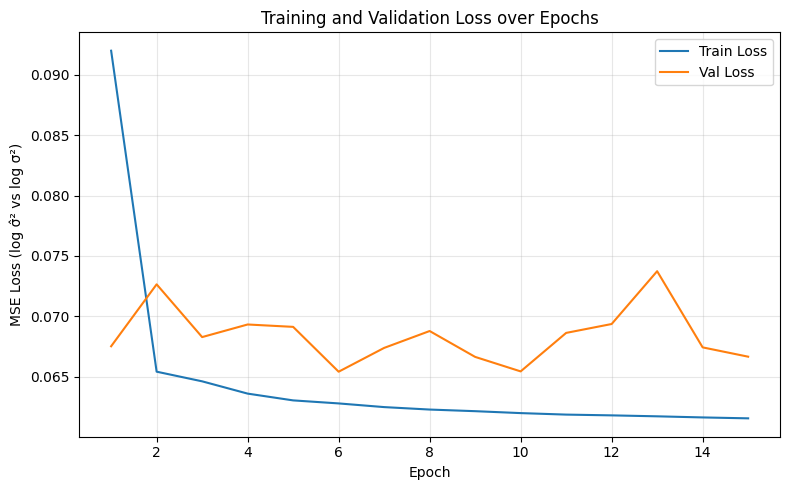


STEP 6: MULTI-SERIES PARAMETER VISUALIZATION (VALIDATION, EXTRAPOLATION)

[Multi-Series] Variance prediction quality on validation set (scaled σ²):
  Val MSE: 1.4370e-01
  Val MAE: 1.4147e-01
  Val R² : 0.9810

[Multi-Series] Parameter error summary (NN, validation):
  Mean |ω_hat - ω|      : 1.8962e-02
  Mean |α_hat - α|      : 6.8606e-02
  Mean |β_hat - β|      : 6.1294e-02
  Mean rel error ω      : 50.75%
  Mean rel error α      : 402.85%
  Mean rel error β      : 8.37%

[Comparison: NN vs arch_model vs true parameters]
  Mean |ω̂_NN   - ω|   : 1.8962e-02
  Mean |ω̂_arch - ω|   : 3.9875e-02
  Mean |α̂_NN   - α|   : 6.8606e-02
  Mean |α̂_arch - α|   : 4.5106e-02
  Mean |β̂_NN   - β|   : 6.1294e-02
  Mean |β̂_arch - β|   : 9.3824e-02

  Persistence C = α+β :
    Mean true C        : 0.8707
    Mean NN   Ĉ       : 0.8717
    Mean arch Ĉ       : 0.8615
    MAE C NN           : 5.6176e-02
    MAE C arch         : 6.3427e-02
Saved NN vs ARCH parameter error comparison to 'garch_nn_vs_a

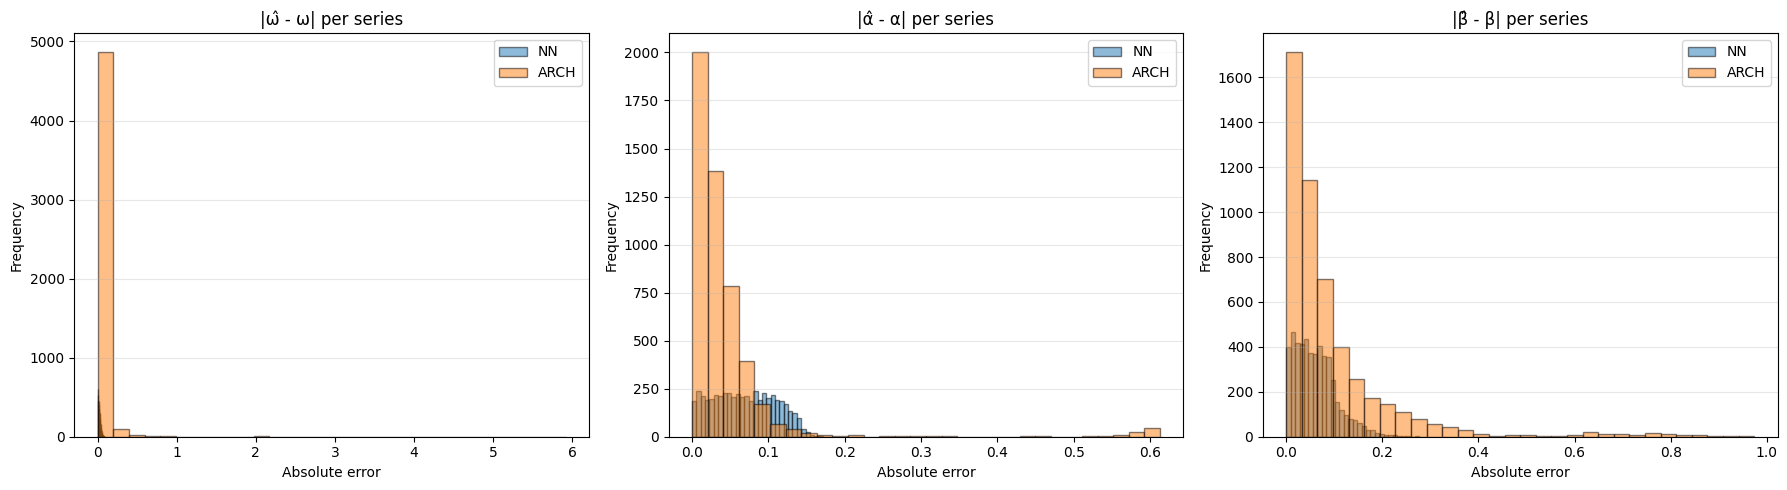

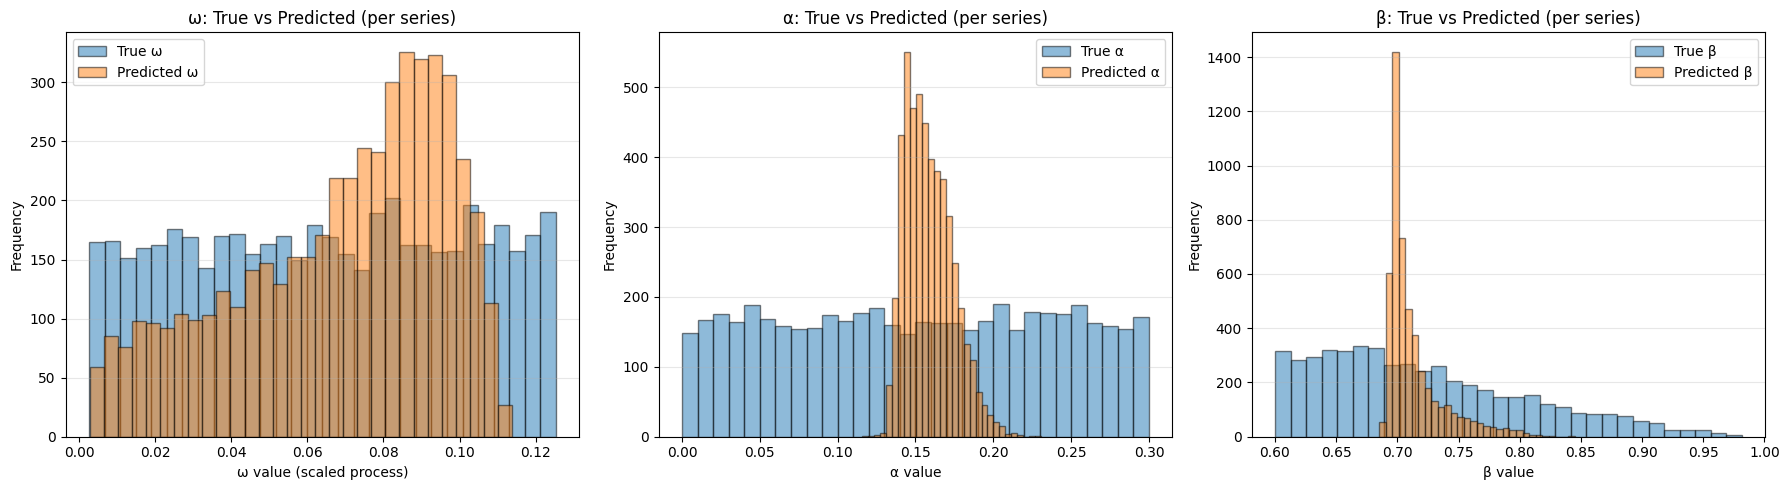

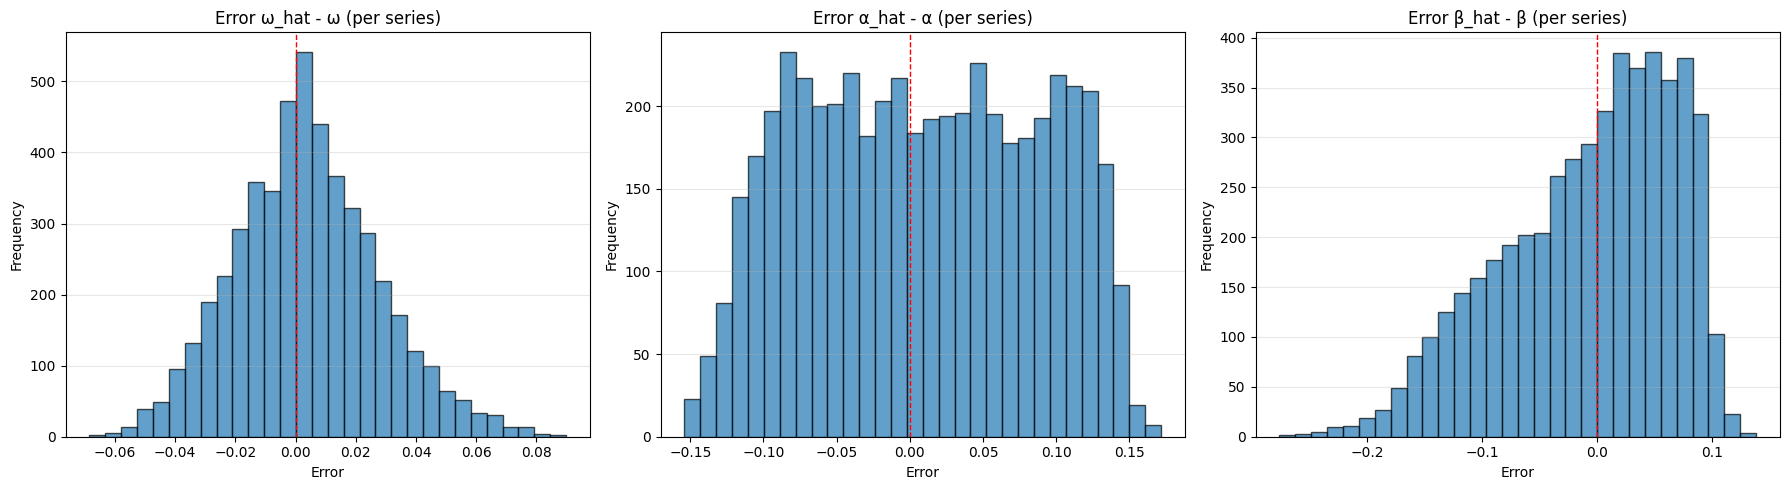

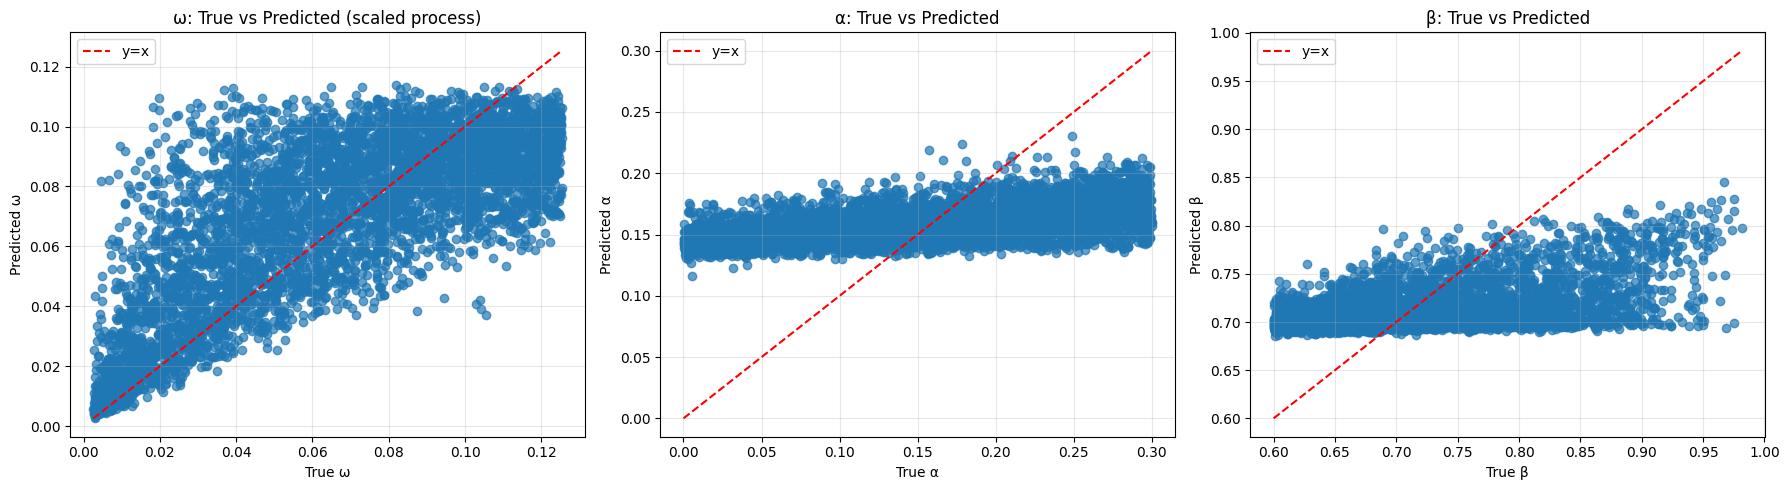

Mean true α+β : 0.8706698810388381
Mean pred α+β : 0.8717497952207923
Min pred α+β  : 0.8286969810724258
Max pred α+β  : 0.9854493141174316

Multi-series metrics summary (validation, scaled σ²):
  val_mse: 0.143697
  val_mae: 0.141470
  val_r2: 0.981037
  omega_abs_err_mean: 0.018962
  alpha_abs_err_mean: 0.068606
  beta_abs_err_mean: 0.061294

Key OOS metric: R² on σ²_t+1 (validation, scaled) = 0.9810

[Forecast comparison on validation set (σ²_{t+1}, standardised process) — EXTRAPOLATION]
  NN–GARCH   MSE = 1.4370e-01, MAE = 1.4147e-01, R² = 0.9810
  GARCH(1,1) MSE = 1.2149e-01, MAE = 8.2776e-02, R² = 0.9839
  GARCH(1,1) MSE on σ_(t+1) (std): 6.5642e-03
Saved NN vs ARCH forecast comparison to 'sigma2_forecast_nn_vs_arch_series0_extrapolation.png'


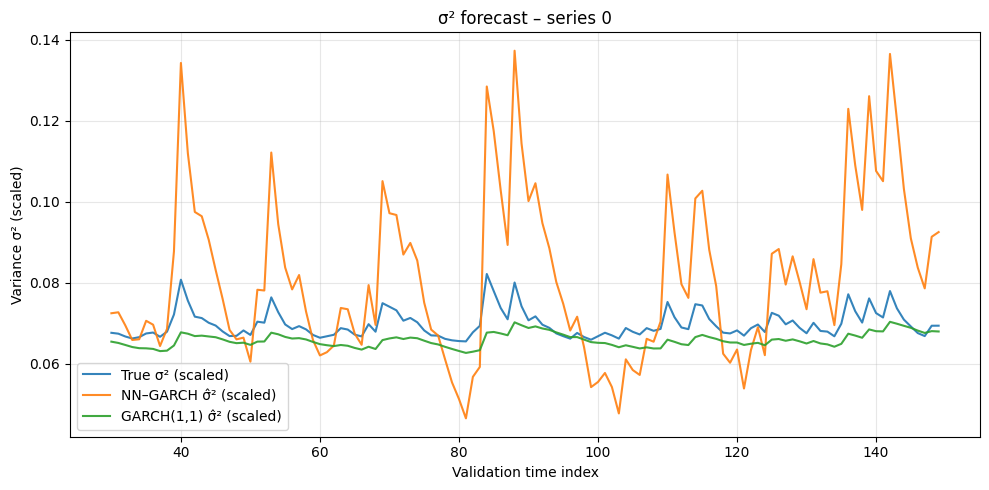


STEP 7: α TRUE vs α PRED (TRAIN / VAL / TEST) — EXTRAPOLATION
Saved Train (extrapolation) α true vs predicted scatter to 'alpha_true_vs_pred_train_extrapolation.png'


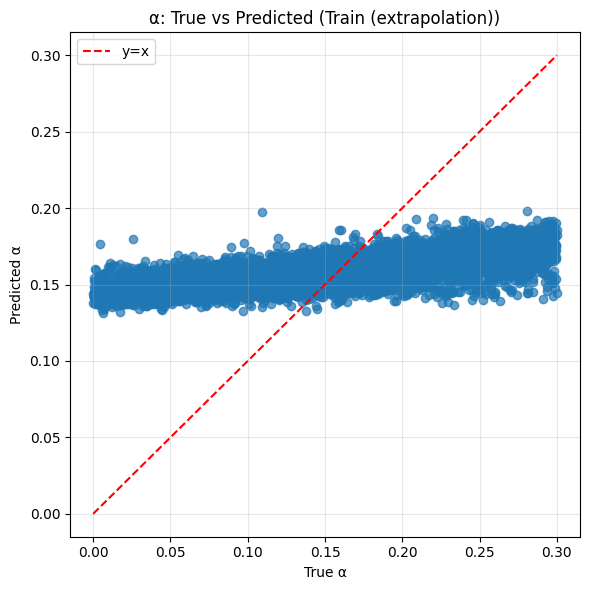

Saved Validation (extrapolation) α true vs predicted scatter to 'alpha_true_vs_pred_val_extrapolation.png'


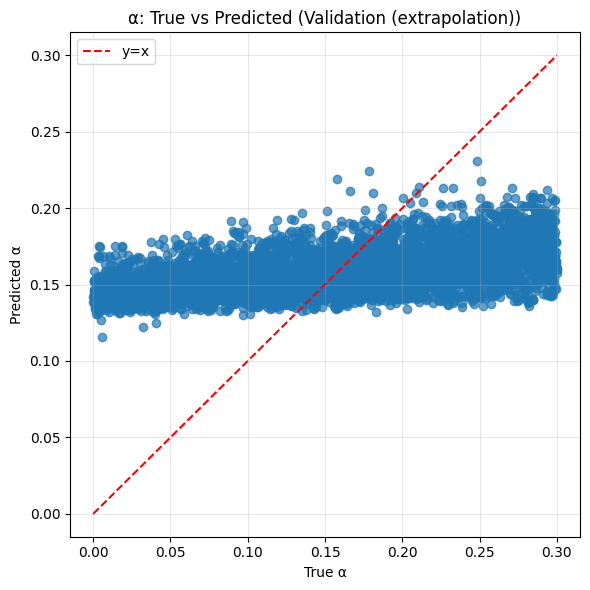

Saved Test (extrapolation) α true vs predicted scatter to 'alpha_true_vs_pred_test_extrapolation.png'


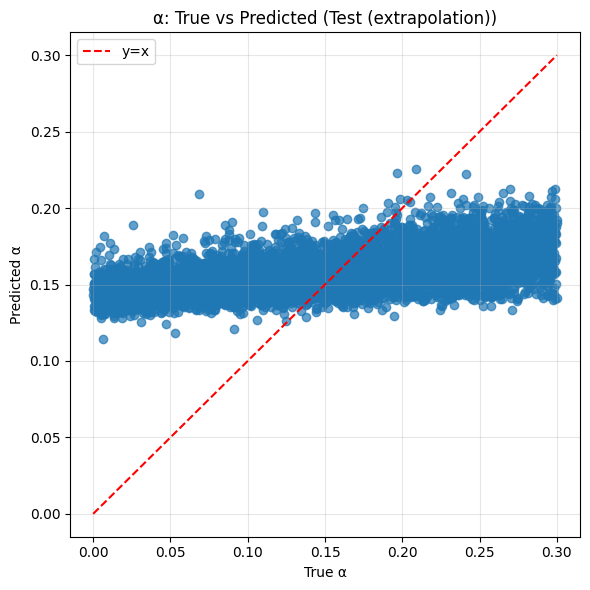


EXTRAPOLATION EXPERIMENT COMPLETED SUCCESSFULLY!

Key Achievements:
  ✓ NN successfully learned to approximate (scaled) GARCH parameters in extrapolation regime
  ✓ Dynamic volatility layer captures time-varying variance on standardised returns
  ✓ Model maintains stationarity constraint (α + β < 1) via parameter projection
  ✓ Loss trained on log-variance log(σ²) for more stable optimisation

Generated Files (extrapolation):
  - training_curves_extrapolation.png
  - garch_multi_param_distributions.png
  - garch_multi_param_errors.png
  - garch_multi_param_scatter.png
  - garch_nn_vs_arch_param_errors.png
  - sigma2_forecast_nn_vs_arch_series0_extrapolation.png
  - alpha_true_vs_pred_train_extrapolation.png
  - alpha_true_vs_pred_val_extrapolation.png
  - alpha_true_vs_pred_test_extrapolation.png
  - best_garch_model_extrapolation.pt (saved model weights)
  - hybrid_garch_pretrained_extrap.pt


In [ ]:
# ============================================================================
# 10. MAIN EXAMPLE WITH FULL WORKFLOW — EXTRAPOLATION REGIME
# ============================================================================

def main():
    """
    EXTRAPOLATION workflow:
    Generate MULTI-SERIES GARCH data with
        alpha ∈ [0, 0.3], beta ∈ [0.6, 0.99], alpha+beta < 1,
    train hybrid NN-GARCH model, and perform comprehensive evaluation.
    """
    print("=" * 80)
    print("HYBRID GARCH(1,1) + NEURAL NETWORK MODEL — EXTRAPOLATION REGIME")
    print("Dynamic Volatility Layer with Parameter Learning (MULTI-SERIES)")
    print("Standardised returns + log-variance training")
    print("alpha ∈ [0, 0.3], beta ∈ [0.6, 0.99], alpha+beta < 1")
    print("=" * 80)
    print()

    # ========== Configuration ==========
    N_SERIES   = 5000
    N_SAMPLES  = 1000
    TRAIN_SPLIT = 0.7
    VAL_SPLIT   = 0.15   # reste pour test éventuel
    TEST_SPLIT  = 1.0 - TRAIN_SPLIT - VAL_SPLIT

    # ------------------------------------------------------------------
    # Sample GARCH parameters for each series (true parameters - ORIGINAL SCALE)
    # EXTRAPOLATION REGIME: alpha ∈ [0, 0.3], beta ∈ [0.6, 0.99], alpha+beta < 1
    # ------------------------------------------------------------------
    TRUE_OMEGAS = np.random.uniform(0.001, 0.05, size=N_SERIES)

    # alpha in [0, 0.3]
    TRUE_ALPHAS = np.random.uniform(0.0, 0.3, size=N_SERIES)
    # beta in [0.6, 0.99]
    TRUE_BETAS  = np.random.uniform(0.6, 0.99, size=N_SERIES)

    # enforce alpha + beta < 0.99 (stationary & margin)
    mask_bad = (TRUE_ALPHAS + TRUE_BETAS) >= 0.99
    while np.any(mask_bad):
        # on ne resample que les β problématiques
        TRUE_BETAS[mask_bad] = np.random.uniform(0.6, 0.99, size=mask_bad.sum())
        mask_bad = (TRUE_ALPHAS + TRUE_BETAS) >= 0.99

    print(f"Sampling random GARCH parameters for {N_SERIES} series (EXTRAPOLATION)...")
    print("Example (first 5):")
    for j in range(5):
        print(
            f"Series {j}: "
            f"omega={TRUE_OMEGAS[j]:.4f}, "
            f"alpha={TRUE_ALPHAS[j]:.4f}, "
            f"beta={TRUE_BETAS[j]:.4f}, "
            f"alpha+beta={TRUE_ALPHAS[j] + TRUE_BETAS[j]:.4f}"
        )

    # Model configuration
    WINDOW_SIZE = 30
    HIDDEN_DIM  = 128

    # Training configuration
    BATCH_SIZE    = 2048
    N_EPOCHS      = 15
    LEARNING_RATE = 1e-3

    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\nUsing device: {device}\n")

    # ========== Step 1: Generate GARCH Data Series ==========
    all_returns_list   = []
    all_variances_list = []

    for j in range(N_SERIES):
        generator = GARCHGenerator(
            omega=float(TRUE_OMEGAS[j]),
            alpha=float(TRUE_ALPHAS[j]),
            beta=float(TRUE_BETAS[j]),
            n_samples=N_SAMPLES,
            seed=42 + j  # different seed per series
        )

        returns_j, variances_j = generator.generate_series()
        all_returns_list.append(returns_j)
        all_variances_list.append(variances_j)

    # Stack into tensors: shape [N_SERIES, N_SAMPLES]
    all_returns   = torch.stack(all_returns_list,   dim=0)  # ORIGINAL scale
    all_variances = torch.stack(all_variances_list, dim=0)  # ORIGINAL σ²

    print(f"\nGenerated {N_SERIES} GARCH series (EXTRAPOLATION):")
    print(f"  all_returns shape:   {all_returns.shape}")
    print(f"  all_variances shape: {all_variances.shape}")

    # ========== Step 1bis: Global standardisation of returns + rescale σ² ==========
    # We standardise returns globally: r_std = (r - mean) / std
    # Then σ²_std = σ² / std^2
    mean_r = all_returns.mean()
    std_r  = all_returns.std()
    std_r_f = float(std_r)

    all_returns   = (all_returns - mean_r) / (std_r + 1e-8)
    all_variances = all_variances / ((std_r + 1e-8) ** 2)

    print(f"\nStandardised returns globally:")
    print(f"  mean ≈ {float(all_returns.mean()):.4f}, std ≈ {float(all_returns.std()):.4f}")
    print(f"  Scale factor used (std of original returns): {std_r_f:.4f}")

    # On the standardised process, the true parameters become:
    # ω' = ω / std^2, α' = α, β' = β
    TRUE_OMEGAS_SCALED = TRUE_OMEGAS / (std_r_f ** 2)
    TRUE_ALPHAS_SCALED = TRUE_ALPHAS
    TRUE_BETAS_SCALED  = TRUE_BETAS

    # ========== Step 2: Create Train/Val/Test datasets from ALL series ==========
    train_len = int(TRAIN_SPLIT * N_SAMPLES)
    val_len   = int(VAL_SPLIT   * N_SAMPLES)
    test_len  = N_SAMPLES - train_len - val_len

    train_returns   = all_returns[:, :train_len]                       # [N_SERIES, train_len]
    train_variances = all_variances[:, :train_len]

    val_returns     = all_returns[:, train_len:train_len + val_len]    # [N_SERIES, val_len]
    val_variances   = all_variances[:, train_len:train_len + val_len]

    test_returns    = all_returns[:, train_len + val_len:]             # [N_SERIES, test_len]
    test_variances  = all_variances[:, train_len + val_len:]

    print(f"\nTrain time length: {train_len}")
    print(f"Val time length:   {val_len}")
    print(f"Test time length:  {test_len}")

    # ========= 2b. Fit classical GARCH(1,1) with arch_model on TRAIN only =========
    # NOTE: arch_model sees STANDARDISED returns here.
    garch_omega_hat = np.zeros(N_SERIES)
    garch_alpha_hat = np.zeros(N_SERIES)
    garch_beta_hat  = np.zeros(N_SERIES)

    for j in range(N_SERIES):
        r_train = train_returns[j].numpy()   # shape [train_len], standardised
        am = arch_model(
            r_train,
            vol='GARCH',
            p=1,
            q=1,
            mean='Zero',
            dist='normal',
            rescale=False,    # IMPORTANT si tu veux éviter que ARCH refasse son propre rescale
        )

        res = am.fit(disp='off')

        garch_omega_hat[j] = res.params['omega']
        garch_alpha_hat[j] = res.params['alpha[1]']
        garch_beta_hat[j]  = res.params['beta[1]']

    #If PB with ARCH alpha + beta > 1 we can see here
    C_true = TRUE_ALPHAS_SCALED + TRUE_BETAS_SCALED
    C_arch = garch_alpha_hat + garch_beta_hat

    print("True C = α+β (mean/min/max):",
          C_true.mean(), C_true.min(), C_true.max())
    print("ARCH Ĉ = α̂+β̂ (mean/min/max):",
          C_arch.mean(), C_arch.min(), C_arch.max())

    print("omega true (scaled) mean/min/max:",
          TRUE_OMEGAS_SCALED.mean(), TRUE_OMEGAS_SCALED.min(), TRUE_OMEGAS_SCALED.max())
    print("omega_hat ARCH mean/min/max:",
          garch_omega_hat.mean(), garch_omega_hat.min(), garch_omega_hat.max())

    # ---------- Projection des paramètres ARCH dans le même domaine que le générateur ----------
    C_min, C_max = C_true.min(), C_true.max()   # domaine de persistance dans ces données
    C_hat = garch_alpha_hat + garch_beta_hat   # α̂ + β̂

    # On clip Ĉ dans [C_min, C_max]
    C_clipped = np.clip(C_hat, C_min, C_max)

    # On rescale α̂ et β̂ pour que α̂+β̂ devienne C_clipped
    scale = C_clipped / (C_hat + 1e-8)
    garch_alpha_hat *= scale
    garch_beta_hat  *= scale

    # Par curiosité, on regarde après projection
    C_arch_proj = garch_alpha_hat + garch_beta_hat
    print("ARCH Ĉ after projection (mean/min/max):",
          C_arch_proj.mean(), C_arch_proj.min(), C_arch_proj.max())

    # ========= Step 2c: Build PyTorch datasets and loaders =========
    train_dataset = MultiGARCHDataset(train_returns, train_variances, WINDOW_SIZE)
    val_dataset   = MultiGARCHDataset(val_returns,   val_variances,   WINDOW_SIZE)
    test_dataset  = MultiGARCHDataset(test_returns,  test_variances,  WINDOW_SIZE)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=4, pin_memory=True)
    val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=4, pin_memory=True)

    print(f"\nTrain samples: {len(train_dataset)}")
    print(f"Val samples:   {len(val_dataset)}")
    print(f"Test samples:  {len(test_dataset)}")
    print(f"Train batches: {len(train_loader)}")
    print(f"Val batches:   {len(val_loader)}")

    # ========== Step 3: Initialize Model ==========
    print("\n" + "=" * 80)
    print("STEP 3: INITIALIZING HYBRID MODEL (EXTRAPOLATION)")
    print("=" * 80)

    model = HybridGARCHModel(input_seq_len=WINDOW_SIZE, hidden_dim=HIDDEN_DIM)
    model = model.to(device)

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model architecture:")
    print(f"  Parameter Network: Conv1d → MLP → (ω, α, β)")
    print(f"  Volatility Layer:  GARCH(1,1) recursion")
    print(f"  Total trainable parameters: {total_params:,}")

    print(f"\nModel structure:")
    print(model)

    # ========== Step 4: Train Model ==========
    print("\n" + "=" * 80)
    print("STEP 4: TRAINING HYBRID MODEL (EXTRAPOLATION)")
    print("=" * 80)
    print(f"Epochs: {N_EPOCHS}")
    print(f"Learning rate: {LEARNING_RATE}")
    print(f"Optimizer: Adam with weight decay")
    print(f"Loss: MSE between predicted and true log-variance log(σ²)")
    print()

    history = train_hybrid_garch(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        n_epochs=N_EPOCHS,
        learning_rate=LEARNING_RATE,
        device=device,
        checkpoint_path="best_garch_model_extrapolation.pt",  # ← nouveau nom
        load_best=True,
    )

    # ======= SAUVEGARDE DU MODELE PRE-ENTRAINE SUR DONNEES SYNTHETIQUES (EXTRAPOLATION) =======
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "window_size": WINDOW_SIZE,
        "hidden_dim": HIDDEN_DIM,
        "mean_r": float(mean_r),
        "std_r": float(std_r),
        "n_series": N_SERIES,
        "n_samples": N_SAMPLES,
        "true_omegas": TRUE_OMEGAS_SCALED,
        "true_alphas": TRUE_ALPHAS_SCALED,
        "true_betas": TRUE_BETAS_SCALED,
    }

    torch.save(checkpoint, "hybrid_garch_pretrained_extrap.pt")
    print("\nSaved EXTRAPOLATION pretrained model to 'hybrid_garch_pretrained_extrap.pt'")

    # ========== Step 5: Global Loss Summary ==========
    print("\n" + "=" * 80)
    print("STEP 5: GLOBAL TRAINING SUMMARY (EXTRAPOLATION)")
    print("=" * 80)

    print("\nLoss Summary (log-variance MSE):")
    print(f"  Initial train loss: {history['train_loss'][0]:.6f}")
    print(f"  Final train loss:   {history['train_loss'][-1]:.6f}")
    print(f"  Final val loss:     {history['val_loss'][-1]:.6f}")
    print(f"  Loss reduction:     {(1 - history['train_loss'][-1] / history['train_loss'][0]) * 100:.2f}%")

    # ========== Step 5bis: Plot Training Curves ==========
    plot_training_curves(history, save_path="training_curves_extrapolation.png")

    # ========== Step 6: Multi-Series Visualizations (VALIDATION) ==========
    print("\n" + "=" * 80)
    print("STEP 6: MULTI-SERIES PARAMETER VISUALIZATION (VALIDATION, EXTRAPOLATION)")
    print("=" * 80)

    multi_metrics = create_visualizations_multi(
        model=model,
        val_dataset=val_dataset,         # MultiGARCHDataset (std scale)
        true_omegas=TRUE_OMEGAS_SCALED,  # true params on std process
        true_alphas=TRUE_ALPHAS_SCALED,
        true_betas=TRUE_BETAS_SCALED,
        device=device,
        batch_size=BATCH_SIZE,
        garch_omegas=garch_omega_hat,
        garch_alphas=garch_alpha_hat,
        garch_betas=garch_beta_hat,
    )

    print("\nMulti-series metrics summary (validation, scaled σ²):")
    for k, v in multi_metrics.items():
        print(f"  {k}: {v:.6f}")
    print(f"\nKey OOS metric: R² on σ²_t+1 (validation, scaled) = {multi_metrics['val_r2']:.4f}")

    # ========== Step 6bis: Forecast comparison NN–GARCH vs classical GARCH(1,1) ==========
    all_returns_np   = all_returns.numpy()      # [N_SERIES, N_SAMPLES], std
    all_variances_np = all_variances.numpy()    # [N_SERIES, N_SAMPLES], σ² std

    arch_sigma2_hat = np.zeros_like(all_returns_np)  # même shape

    for j in range(N_SERIES):
        arch_sigma2_hat[j, :] = compute_garch_variance_from_params(
            returns=all_returns_np[j, :],
            omega=garch_omega_hat[j],
            alpha=garch_alpha_hat[j],
            beta=garch_beta_hat[j],
        )

    arch_val_sigma2 = arch_sigma2_hat[:, train_len:train_len + val_len]       # [N_SERIES, val_len]
    true_val_sigma2 = all_variances_np[:, train_len:train_len + val_len]      # [N_SERIES, val_len]

    targets_flat = []
    arch_flat    = []

    for j in range(N_SERIES):
        for t in range(val_len - WINDOW_SIZE):
            idx = t + WINDOW_SIZE
            targets_flat.append(true_val_sigma2[j, idx])      # vraie σ²_t+1 (std)
            arch_flat.append(arch_val_sigma2[j, idx])         # σ̂²_t+1 GARCH (std)

    targets_flat = np.array(targets_flat)
    arch_flat    = np.array(arch_flat)

    mse_arch = np.mean((arch_flat - targets_flat)**2)
    mae_arch = np.mean(np.abs(arch_flat - targets_flat))
    r2_arch  = np.corrcoef(targets_flat, arch_flat)[0, 1]**2

    print("\n[Forecast comparison on validation set (σ²_{t+1}, standardised process) — EXTRAPOLATION]")
    print(f"  NN–GARCH   MSE = {multi_metrics['val_mse']:.4e}, "
          f"MAE = {multi_metrics['val_mae']:.4e}, "
          f"R² = {multi_metrics['val_r2']:.4f}")
    print(f"  GARCH(1,1) MSE = {mse_arch:.4e}, "
          f"MAE = {mae_arch:.4e}, "
          f"R² = {r2_arch:.4f}")

    sigma_true = np.sqrt(np.clip(targets_flat, 1e-12, None))
    sigma_arch = np.sqrt(np.clip(arch_flat,    1e-12, None))
    mse_sigma_arch = np.mean((sigma_arch - sigma_true)**2)
    print(f"  GARCH(1,1) MSE on σ_(t+1) (std): {mse_sigma_arch:.4e}")

    # ========== Step 6ter: Visual comparison of σ² forecasts on one series ==========
    plot_forecast_comparison_nn_vs_arch(
        model=model,
        val_returns=val_returns,             # torch.Tensor [N_SERIES, val_len] std
        true_val_sigma2=true_val_sigma2,     # np.ndarray   [N_SERIES, val_len] std
        arch_val_sigma2=arch_val_sigma2,     # np.ndarray   [N_SERIES, val_len] std
        window_size=WINDOW_SIZE,
        device=device,
        series_idx=0,                        # change to 1,2,... for other series
        save_path="sigma2_forecast_nn_vs_arch_series0_extrapolation.png",
    )

    # ========== Step 7: α_true vs α_pred plots for TRAIN / VAL / TEST ==========
    print("\n" + "=" * 80)
    print("STEP 7: α TRUE vs α PRED (TRAIN / VAL / TEST) — EXTRAPOLATION")
    print("=" * 80)

    alpha_hat_train = collect_alpha_per_series(model, train_dataset, device, batch_size=BATCH_SIZE)
    alpha_hat_val   = collect_alpha_per_series(model, val_dataset,   device, batch_size=BATCH_SIZE)
    alpha_hat_test  = collect_alpha_per_series(model, test_dataset,  device, batch_size=BATCH_SIZE)

    plot_alpha_true_vs_pred(TRUE_ALPHAS_SCALED, alpha_hat_train,
                            "Train (extrapolation)", "alpha_true_vs_pred_train_extrapolation.png")
    plot_alpha_true_vs_pred(TRUE_ALPHAS_SCALED, alpha_hat_val,
                            "Validation (extrapolation)", "alpha_true_vs_pred_val_extrapolation.png")
    plot_alpha_true_vs_pred(TRUE_ALPHAS_SCALED, alpha_hat_test,
                            "Test (extrapolation)", "alpha_true_vs_pred_test_extrapolation.png")

    # ========== Summary ==========
    print("\n" + "=" * 80)
    print("EXTRAPOLATION EXPERIMENT COMPLETED SUCCESSFULLY!")
    print("=" * 80)
    print("\nKey Achievements:")
    print("  ✓ NN successfully learned to approximate (scaled) GARCH parameters in extrapolation regime")
    print("  ✓ Dynamic volatility layer captures time-varying variance on standardised returns")
    print("  ✓ Model maintains stationarity constraint (α + β < 1) via parameter projection")
    print("  ✓ Loss trained on log-variance log(σ²) for more stable optimisation")
    print("\nGenerated Files (extrapolation):")
    print("  - training_curves_extrapolation.png")
    print("  - garch_multi_param_distributions.png")
    print("  - garch_multi_param_errors.png")
    print("  - garch_multi_param_scatter.png")
    print("  - garch_nn_vs_arch_param_errors.png")
    print("  - sigma2_forecast_nn_vs_arch_series0_extrapolation.png")
    print("  - alpha_true_vs_pred_train_extrapolation.png")
    print("  - alpha_true_vs_pred_val_extrapolation.png")
    print("  - alpha_true_vs_pred_test_extrapolation.png")
    print("  - best_garch_model_extrapolation.pt (saved model weights)")
    print("  - hybrid_garch_pretrained_extrap.pt")
    print("=" * 80)


# et tu laisses ton appel comme avant :
main()


# pre train fin-tunning and comparaison

FINE-TUNING EXTRAPOLATION HYBRID GARCH(1,1) + NN ON REAL MARKET DATA
Start from EXTRAPOLATION synthetic pretraining, then adapt on yfinance data
Using device: cuda

Loaded checkpoint 'hybrid_garch_pretrained_extrap.pt'
  window_size  = 30
  hidden_dim   = 128
  n_samples    = 1000
  mean_r_synth = 8.1228e-05, std_r_synth = 6.3157e-01

Got 14 real series from yfinance.
First 10 tickers used: ['^GSPC', 'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'JPM', 'XOM']

Standardised real returns with EXTRAPOLATION synthetic stats:
  mean ≈ 0.0007, std ≈ 0.0354

Train time length: 700
Val time length:   150
Test time length:  150

Train samples: 9380
Val samples:   1680
Test samples:  1680

Fitting classical GARCH(1,1) on TRAIN for each series...
Mean (alpha+beta) across series (ARCH): 0.9456135536661447

Evaluating PRETRAINED (EXTRAPOLATION) NN–GARCH on validation (before fine-tuning)...

FINE-TUNING EXTRAPOLATION NN–GARCH ON REAL DATA
Starting training...
Epoch    Train Loss   Val Lo

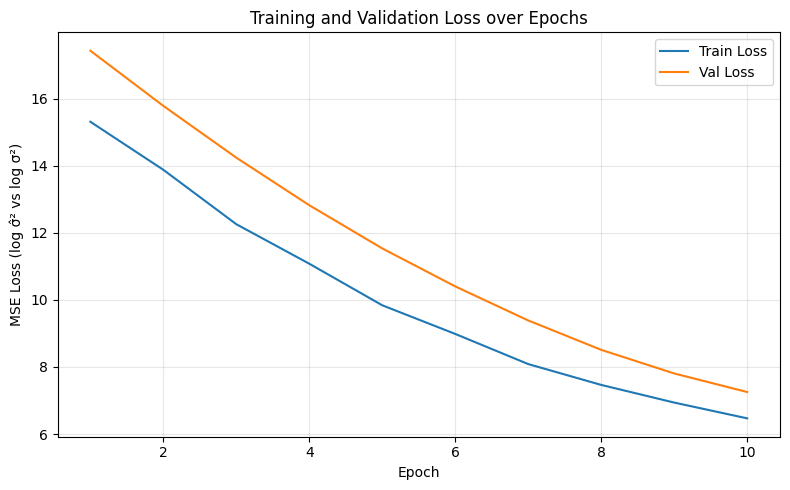


COMPARISON ON VALIDATION (REAL DATA, EXTRAPOLATION MODEL, proxy var = r^2)
Pretrained EXTRAPOLATION NN–GARCH:
  MSE = 7.0900e-05
  MAE = 7.3939e-03
  R²  = 0.0656

Fine-tuned EXTRAPOLATION NN–GARCH:
  MSE = 2.7470e-05
  MAE = 1.5264e-03
  R²  = 0.0572

GARCH(1,1) (ARCH library):
  MSE = 2.6913e-05
  MAE = 1.6840e-03
  R²  = 0.0659
  MSE on σ_(t+1) = 8.4258e-04
Saved 3-way forecast comparison to 'sigma2_forecast_extrap_pre_vs_ft_vs_arch_series0_real.png'


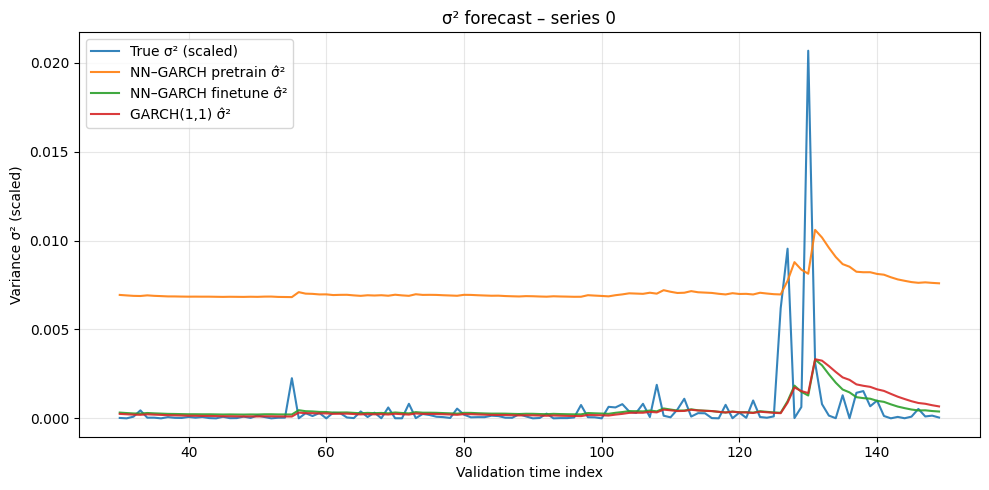


Saved fine-tuned EXTRAPOLATION model weights to 'hybrid_garch_finetuned_real_extrap.pt'

FINE-TUNING EXTRAPOLATION EXPERIMENT COMPLETED.


In [ ]:
import copy
# ================================================================
# FINE-TUNING DU MODELE EXTRAPOLATION SUR DONNEES REELLES + ARCH
# ================================================================
def main_finetune_on_real_extrap():
    print("=" * 80)
    print("FINE-TUNING EXTRAPOLATION HYBRID GARCH(1,1) + NN ON REAL MARKET DATA")
    print("Start from EXTRAPOLATION synthetic pretraining, then adapt on yfinance data")
    print("=" * 80)

    # ----------------- Device -----------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}\n")

    # ----------------- Charger le checkpoint EXTRAPOLATION -----------------
    ckpt_path = "hybrid_garch_pretrained_extrap.pt"  # <-- ADAPTE LE NOM SI BESOIN
    checkpoint = torch.load(ckpt_path, map_location=device, weights_only=False)
    print(f"Loaded checkpoint '{ckpt_path}'")

    window_size  = checkpoint["window_size"]
    hidden_dim   = checkpoint["hidden_dim"]
    n_samples    = checkpoint["n_samples"]
    mean_r_synth = checkpoint["mean_r"]
    std_r_synth  = checkpoint["std_r"]

    print(f"  window_size  = {window_size}")
    print(f"  hidden_dim   = {hidden_dim}")
    print(f"  n_samples    = {n_samples}")
    print(f"  mean_r_synth = {mean_r_synth:.4e}, std_r_synth = {std_r_synth:.4e}")

    # ----------------- Reconstruire le modèle & copie pré-trainée -----------------
    model = HybridGARCHModel(input_seq_len=window_size,
                             hidden_dim=hidden_dim).to(device)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    pretrained_state_dict = copy.deepcopy(model.state_dict())

    # ----------------- Config données réelles -----------------
    TARGET_N_SERIES = 200
    N_SAMPLES       = n_samples
    TRAIN_SPLIT = 0.7
    VAL_SPLIT   = 0.15
    TEST_SPLIT  = 1.0 - TRAIN_SPLIT - VAL_SPLIT

    TICKERS = [
        "^GSPC",
        "AAPL", "MSFT", "GOOGL", "AMZN", "META",
        "TSLA", "NVDA", "JPM", "XOM",
        "OR.PA", "AIR.PA", "MC.PA", "BNP.PA",
    ]

    # ----------------- 1) Télécharger log-returns réels -----------------
    all_returns_raw, used_tickers = download_log_returns_for_tickers(
        TICKERS,
        n_series_target=TARGET_N_SERIES,
        n_samples=N_SAMPLES,
        verbose=True,
    )

    print(f"\nGot {all_returns_raw.shape[0]} real series from yfinance.")
    print("First 10 tickers used:", used_tickers[:10])

    assert isinstance(all_returns_raw, torch.Tensor)
    if all_returns_raw.dim() == 3 and all_returns_raw.size(-1) == 1:
        all_returns_raw = all_returns_raw.squeeze(-1)

    assert all_returns_raw.dim() == 2, f"Expected [N_SERIES, N_SAMPLES], got {all_returns_raw.shape}"
    N_SERIES = all_returns_raw.shape[0]

    # ----------------- 2) Standardisation avec stats synthétiques (EXTRAPOLATION) -----------------
    all_returns   = (all_returns_raw - mean_r_synth) / (std_r_synth + 1e-8)
    all_variances = all_returns ** 2

    print("\nStandardised real returns with EXTRAPOLATION synthetic stats:")
    print(f"  mean ≈ {float(all_returns.mean()):.4f}, std ≈ {float(all_returns.std()):.4f}")

    # ----------------- 3) Split temporel train / val / test -----------------
    train_len = int(TRAIN_SPLIT * N_SAMPLES)
    val_len   = int(VAL_SPLIT   * N_SAMPLES)
    test_len  = N_SAMPLES - train_len - val_len

    train_returns   = all_returns[:, :train_len]
    val_returns     = all_returns[:, train_len:train_len + val_len]
    test_returns    = all_returns[:, train_len + val_len:]

    train_variances = all_variances[:, :train_len]
    val_variances   = all_variances[:, train_len:train_len + val_len]
    test_variances  = all_variances[:, train_len + val_len:]

    print(f"\nTrain time length: {train_len}")
    print(f"Val time length:   {val_len}")
    print(f"Test time length:  {test_len}")

    train_dataset = MultiGARCHDataset(train_returns, train_variances, window_size)
    val_dataset   = MultiGARCHDataset(val_returns,   val_variances,   window_size)
    test_dataset  = MultiGARCHDataset(test_returns,  test_variances,  window_size)

    BATCH_SIZE_FT = 2048
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_FT,
                              shuffle=True, num_workers=4, pin_memory=True)
    val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE_FT,
                              shuffle=False, num_workers=4, pin_memory=True)

    print(f"\nTrain samples: {len(train_dataset)}")
    print(f"Val samples:   {len(val_dataset)}")
    print(f"Test samples:  {len(test_dataset)}")

    # ----------------- 4) GARCH(1,1) classique sur TRAIN -----------------
    print("\nFitting classical GARCH(1,1) on TRAIN for each series...")
    garch_omega_hat = np.zeros(N_SERIES)
    garch_alpha_hat = np.zeros(N_SERIES)
    garch_beta_hat  = np.zeros(N_SERIES)

    for j in range(N_SERIES):
        r_train = train_returns[j].numpy()
        am = arch_model(
            r_train,
            vol='GARCH',
            p=1,
            q=1,
            mean='Zero',
            dist='normal',
            rescale=False,
        )
        res = am.fit(disp='off')
        garch_omega_hat[j] = res.params['omega']
        garch_alpha_hat[j] = res.params['alpha[1]']
        garch_beta_hat[j]  = res.params['beta[1]']

    print("Mean (alpha+beta) across series (ARCH):",
          float((garch_alpha_hat + garch_beta_hat).mean()))

    all_returns_np  = all_returns.numpy()
    arch_sigma2_hat = np.zeros_like(all_returns_np)
    for j in range(N_SERIES):
        arch_sigma2_hat[j, :] = compute_garch_variance_from_params(
            returns=all_returns_np[j, :],
            omega=garch_omega_hat[j],
            alpha=garch_alpha_hat[j],
            beta=garch_beta_hat[j],
        )

    arch_val_metrics = evaluate_arch_on_validation(
        arch_sigma2_hat=arch_sigma2_hat,
        all_returns_np=all_returns_np,
        train_len=train_len,
        val_len=val_len,
        window_size=window_size,
    )

    # ----------------- 5) Eval PRETRAINED (EXTRAPOLATION) sur validation -----------------
    print("\nEvaluating PRETRAINED (EXTRAPOLATION) NN–GARCH on validation (before fine-tuning)...")
    model_pre = HybridGARCHModel(input_seq_len=window_size,
                                 hidden_dim=hidden_dim).to(device)
    model_pre.load_state_dict(pretrained_state_dict)
    metrics_pre = evaluate_nn_on_dataset(
        model=model_pre,
        dataset=val_dataset,
        device=device,
        batch_size=BATCH_SIZE_FT,
    )

    # ----------------- 6) FINE-TUNING sur données réelles -----------------
    print("\n" + "=" * 80)
    print("FINE-TUNING EXTRAPOLATION NN–GARCH ON REAL DATA")
    print("=" * 80)

    N_EPOCHS_FT      = 10
    LEARNING_RATE_FT = 1e-4

    history_ft = train_hybrid_garch(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        n_epochs=N_EPOCHS_FT,
        learning_rate=LEARNING_RATE_FT,
        device=device,
        checkpoint_path="best_garch_model_finetune_real_extrap.pt",
        load_best=True,
    )

    plot_training_curves(history_ft, save_path="training_curves_finetune_real_extrap.png")

    # ----------------- 7) Eval FINE-TUNED sur validation -----------------
    metrics_ft = evaluate_nn_on_dataset(
        model=model,
        dataset=val_dataset,
        device=device,
        batch_size=BATCH_SIZE_FT,
    )

    # ----------------- 8) PRINT COMPARAISON -----------------
    print("\n" + "=" * 80)
    print("COMPARISON ON VALIDATION (REAL DATA, EXTRAPOLATION MODEL, proxy var = r^2)")
    print("=" * 80)
    print("Pretrained EXTRAPOLATION NN–GARCH:")
    print(f"  MSE = {metrics_pre['mse']:.4e}")
    print(f"  MAE = {metrics_pre['mae']:.4e}")
    print(f"  R²  = {metrics_pre['r2']:.4f}\n")

    print("Fine-tuned EXTRAPOLATION NN–GARCH:")
    print(f"  MSE = {metrics_ft['mse']:.4e}")
    print(f"  MAE = {metrics_ft['mae']:.4e}")
    print(f"  R²  = {metrics_ft['r2']:.4f}\n")

    print("GARCH(1,1) (ARCH library):")
    print(f"  MSE = {arch_val_metrics['mse']:.4e}")
    print(f"  MAE = {arch_val_metrics['mae']:.4e}")
    print(f"  R²  = {arch_val_metrics['r2']:.4f}")
    print(f"  MSE on σ_(t+1) = {arch_val_metrics['mse_sigma']:.4e}")

    # ----------------- 9) PLOT PRE vs FT vs ARCH sur 1 série -----------------
    val_start = train_len
    val_end   = train_len + val_len

    true_val_sigma2 = (all_returns_np[:, val_start:val_end] ** 2)
    arch_val_sigma2 = arch_sigma2_hat[:, val_start:val_end]

    series_to_plot = 0  # change 0 -> 1,2,... pour d'autres séries

    plot_forecast_pre_vs_ft_vs_arch(
        model_pre=model_pre,
        model_ft=model,
        val_returns=val_returns,          # torch.Tensor [N_SERIES, val_len]
        true_val_sigma2=true_val_sigma2,  # np.ndarray   [N_SERIES, val_len]
        arch_val_sigma2=arch_val_sigma2,  # np.ndarray   [N_SERIES, val_len]
        window_size=window_size,
        device=device,
        series_idx=series_to_plot,
        save_path=f"sigma2_forecast_extrap_pre_vs_ft_vs_arch_series{series_to_plot}_real.png",
    )

    # ----------------- 10) Sauvegarde des poids fine-tunés -----------------
    torch.save(model.state_dict(), "hybrid_garch_finetuned_real_extrap.pt")
    print("\nSaved fine-tuned EXTRAPOLATION model weights to 'hybrid_garch_finetuned_real_extrap.pt'")

    print("\nFINE-TUNING EXTRAPOLATION EXPERIMENT COMPLETED.")
    print("=" * 80)

    return {
        "metrics_pretrained_extrap": metrics_pre,
        "metrics_finetuned_extrap": metrics_ft,
        "metrics_arch": arch_val_metrics,
    }

# Dans le notebook, tu lances :
results_finetune_extrap = main_finetune_on_real_extrap()
